In [2]:
from CRTdb3 import *
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import ffn
%matplotlib inline

C:\Users\msteinme\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\io\data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [161]:
ticker = ['WTHR_USA','WTHR_USA_CA','NG_FRONT','NG_FRONT2','NG_FRONT3','NG_FRONT4','NG_FRONT5','NG_FRONT6','NG_FRONT7',
          'NG_FRONT8','NG_FRONT9','NG_FRONT10','NG_FRONT11','NG_FRONT12','NG-HHUB','USA_TOT-ICNG','USA_NET',
         'USA_NG-UNGD-STORAGE','USA_NG-UNGD-STORAGE','USA_NG-UNGD-STORAGE','USA_NG-UNGD-STORAGE','USA_NG-UNGD-STORAGE',
         'USA_NG-UNGD-STORAGE','USA_NG-UNGD-STORAGE','USA_NG-UNGD-STORAGE'] 
field_name = ['GAS_GFS_00Z','AVGTEMP','CLOSE','CLOSE','CLOSE','CLOSE','CLOSE','CLOSE','CLOSE','CLOSE','CLOSE','CLOSE',
             'CLOSE','CLOSE','CLOSE','ENERGY_LOW48','ENERGY_LOW48','ENERGY_SALT','ENERGY_CTL-S','ENERGY_PNW','ENERGY_NONSALT',
             'ENERGY_MTN','ENERGY_MW','ENERGY_LOW48','ENERGY_EAST']
source = ['NCEP_SV','NCEP_REUT','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH',
         'EIA','EIA','EIA','EIA','EIA','EIA','EIA','EIA','EIA','EIA','EIA']

#print(len(ticker))
#print(len(field_name))
#print(len(source))
start_date = '01/02/1996'
end_date = '06/27/2017'
cal_type = 'WD'

crtConn = crtDbOpen()
df = pd.DataFrame()
whole_dataframes = {}
    
for i in range(0,len(ticker)):
            
    period_series_dict = {}                    
    statement ="Select * FROM dbo.CRTGetPeriodSeries('" + start_date + "' , '" + end_date + "' , '" + ticker[i] + "' , '" + field_name[i] + "' , '" + source[i] + "','" + cal_type + "')"
    get_period_series_list = crt_gen_sel (crtConn, statement, None,case="same")
        
    for row in get_period_series_list:
        dt = str(row[0])
        tmpDate = dt.split(' ')
        dt = tmpDate[0]           
        dt = datetime.datetime.strptime(dt,'%Y-%m-%d')
        t_year = dt.year            
        dbDate = str(dt).split(' ')
        dbDate = dbDate[0]
        dbDate = str(dbDate[:len(dbDate)-2] + str(t_year))           
        period_series_dict[dt] = row[1]
            
    statement = " TICKER like '" + ticker[i] + "' AND FIELDNAME = '" + field_name[i] + "' AND DATASOURCE = '" + source[i] + "'"
    TableName = 'CRTTICKERNAME'
    IdColName = 'tickerid'            
    get_id = crt_select_multiple_value(crtConn,TableName, IdColName, statement)            
    statement = " tickerid = " + get_id.get(1)
    statement = statement.replace(',','')
    statement = statement.strip()            
    TableName = 'CRTTICKERVALUE'
    IdColName = 'tickerValueDate,tickerValue'
    PP = crt_select_multiple_value(crtConn,TableName, IdColName, statement)        
    date_list = []
    value_list = []
            
    for key, value in iter(PP.items()):
        temp_value = PP.get(key)
        temp_value = temp_value.split(',')        
        dbValue = float(temp_value[1])
        dbDate = str(temp_value[0])
        dbDate = dbDate.split(' ')
        dbDate = dbDate[0]        
        tmpDate = datetime.datetime.strptime(dbDate,'%Y-%m-%d')               
        t_year = tmpDate.year                
        dbDate = str(dbDate[:len(dbDate)-2] + str(t_year))
                
        if period_series_dict.get(tmpDate):
            period_series_dict[tmpDate] = dbValue
        
    date_list = []
    value_list = [] 
    for key in sorted(period_series_dict.keys()):                
        dbDate = key
        dbValue = period_series_dict.get(key)                
        date_list.append(dbDate)
        value_list.append(dbValue)
        whole_dataframes[i] =  pd.DataFrame()
        
    s_PP = pd.Series(date_list)
    s_PP2 = pd.Series(value_list)
           
    whole_dataframes[i]['Date'] = s_PP
    whole_dataframes[i]['Date'] = pd.to_datetime(whole_dataframes[i]['Date']) #run
    whole_dataframes[i][ticker[i]+'_'+field_name[i]+'_'+source[i]] = s_PP2
            
whole_dataframes[0].index = whole_dataframes[0]['Date'].values  
whole_dataframes[0] = whole_dataframes[0].drop(['Date'],axis=1)
          
for i in range(1,len(ticker)):
    whole_dataframes[i].index = whole_dataframes[i]['Date'].values
    whole_dataframes[i] = whole_dataframes[i].drop(['Date'],axis=1)            
    whole_dataframes[0] = whole_dataframes[0].join(whole_dataframes[i])
df = whole_dataframes[0]

#df = df.dropna()
#df = df.fillna(df.mean())
date = df.index
dateList = []       
for tmp in date:
    tmpDate = str(tmp)  
    t_year = tmp.year
    t_month = tmp.month
    t_day = tmp.day          
    strDate = str(t_month) + '/' + str(t_day) + '/' + str(t_year)    
    dateList.append(strDate)
       
df['Date'] = dateList
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [186]:
df

Date  WTHR_USA_GAS_GFS_00Z_NCEP_SV  \
1996-01-02   1/2/1996                           NaN   
1996-01-03   1/3/1996                           NaN   
1996-01-04   1/4/1996                           NaN   
1996-01-05   1/5/1996                           NaN   
1996-01-08   1/8/1996                           NaN   
1996-01-09   1/9/1996                           NaN   
1996-01-10  1/10/1996                           NaN   
1996-01-11  1/11/1996                           NaN   
1996-01-12  1/12/1996                           NaN   
1996-01-15  1/15/1996                           NaN   
1996-01-16  1/16/1996                           NaN   
1996-01-17  1/17/1996                           NaN   
1996-01-18  1/18/1996                           NaN   
1996-01-19  1/19/1996                           NaN   
1996-01-22  1/22/1996                           NaN   
1996-01-23  1/23/1996                           NaN   
1996-01-24  1/24/1996                           NaN   
1996-01-25  1/25/1996                           NaN   
1996-01-26  1/26/1996                           NaN   
1996-01-29  1/29/1996                           NaN   
1996-01-30  1/30/1996                           NaN   
1996-01-31  1/31/1996                           NaN   
1996-02-01   2/1/1996                           NaN   
1996-02-02   2/2/1996                           NaN   
1996-02-05   2/5/1996                           NaN   
1996-02-06   2/6/1996                           NaN   
1996-02-07   2/7/1996                           NaN   
1996-02-08   2/8/1996                           NaN   
1996-02-09   2/9/1996                           NaN   
1996-02-12  2/12/1996                           NaN   
...               ...                           ...   
2017-05-17  5/17/2017                        2.4825   
2017-05-18  5/18/2017                        3.0933   
2017-05-19  5/19/2017                        4.6765   
2017-05-22  5/22/2017                        4.1206   
2017-05-23  5/23/2017                        3.4574   
2017-05-24  5/24/2017                        3.6238   
2017-05-25  5/25/2017                        4.0295   
2017-05-26  5/26/2017                        2.5986   
2017-05-29  5/29/2017                        2.3562   
2017-05-30  5/30/2017                        2.9164   
2017-05-31  5/31/2017                        1.8014   
2017-06-01   6/1/2017                        1.0534   
2017-06-02   6/2/2017                        0.9648   
2017-06-05   6/5/2017                        1.0283   
2017-06-06   6/6/2017                        2.1906   
2017-06-07   6/7/2017                        1.7543   
2017-06-08   6/8/2017                        1.4531   
2017-06-09   6/9/2017                        0.6672   
2017-06-12  6/12/2017                        1.1578   
2017-06-13  6/13/2017                        0.9161   
2017-06-14  6/14/2017                        0.4537   
2017-06-15  6/15/2017                        0.3624   
2017-06-16  6/16/2017                        0.3055   
2017-06-19  6/19/2017                        0.1155   
2017-06-20  6/20/2017                        0.1503   
2017-06-21  6/21/2017                        0.1846   
2017-06-22  6/22/2017                        0.1283   
2017-06-23  6/23/2017                        0.4643   
2017-06-26  6/26/2017                        1.0453   
2017-06-27  6/27/2017                        0.8836   

            WTHR_USA_CA_AVGTEMP_NCEP_REUT  NG_FRONT_CLOSE_EXCH  \
1996-01-02                          50.72                2.859   
1996-01-03                          48.92                2.986   
1996-01-04                          46.76                2.964   
1996-01-05                          45.50                2.916   
1996-01-08                          52.16                2.916   
1996-01-09                          49.82                2.928   
1996-01-10                          48.92                2.809   
1996-01-11                          51.08                2.490   
1996-01-12  

In [162]:
df2 = df.drop('Date',axis=1)
df2.describe()

WTHR_USA_GAS_GFS_00Z_NCEP_SV  WTHR_USA_CA_AVGTEMP_NCEP_REUT  \
count                    214.000000                    5606.000000   
mean                      12.941312                      58.862865   
std                       10.222960                      12.682208   
min                        0.115500                      28.040000   
25%                        3.508875                      48.560000   
50%                       10.959000                      57.920000   
75%                       21.587575                      70.700000   
max                       41.931000                      87.440000   

       NG_FRONT_CLOSE_EXCH  NG_FRONT2_CLOSE_EXCH  NG_FRONT3_CLOSE_EXCH  \
count          5394.000000           5395.000000           5396.000000   
mean              4.422297              4.518458              4.592172   
std               2.289861              2.339489              2.381799   
min               1.628000              1.661000              1.696000   
25%               2.702000              2.748000              2.808750   
50%               3.823000              3.928000              4.027000   
75%               5.582000              5.684500              5.700000   
max              15.378000             15.427000             15.287000   

       NG_FRONT4_CLOSE_EXCH  NG_FRONT5_CLOSE_EXCH  NG_FRONT6_CLOSE_EXCH  \
count           5395.000000           5394.000000           5394.000000   
mean               4.636911              4.676562              4.706254   
std                2.386847              2.401441              2.403763   
min                1.743000              1.742000              1.739000   
25%                2.837000              2.835250              2.838500   
50%                4.070000              4.076500              4.088500   
75%                5.636000              5.645750              5.705750   
max               14.906000             14.406000             14.516000   

       NG_FRONT7_CLOSE_EXCH  NG_FRONT8_CLOSE_EXCH  \
count           5393.000000           5393.000000   
mean               4.734218              4.754557   
std                2.409987              2.409845   
min                1.742000              1.749000   
25%                2.870000              2.959000   
50%                4.086000              4.047000   
75%                5.780000              5.827000   
max               14.446000             14.166000   

                      ...                   USA_TOT-ICNG_ENERGY_LOW48_EIA  \
count                 ...                                      520.000000   
mean                  ...                                    -7493.614022   
std                   ...                                    32616.752324   
min                   ...                                  -695950.208333   
25%                   ...                                    -6930.156250   
50%                   ...                                    -5538.958333   
75%                   ...                                    -3870.458334   
max                   ...                                     3359.791667   

       USA_NET_ENERGY_LOW48_EIA  USA_NG-UNGD-STORAGE_ENERGY_SALT_EIA  \
count                520.000000                           391.000000   
mean              455104.988862                           240.419437   
std                52091.312185                            83.586056   
min               364854.625000                            54.000000   
25%               412718.041667                           173.500000   
50%               438402.979167                           254.000000   
75%               493699.354167                           306.500000   
max               586768.916667                           403.000000   

       USA_NG-UNGD-STORAGE_ENERGY_CTL-S_EIA  \
count                            391.000000   
mean                             977.028133   
std                              223.893649   
min                     

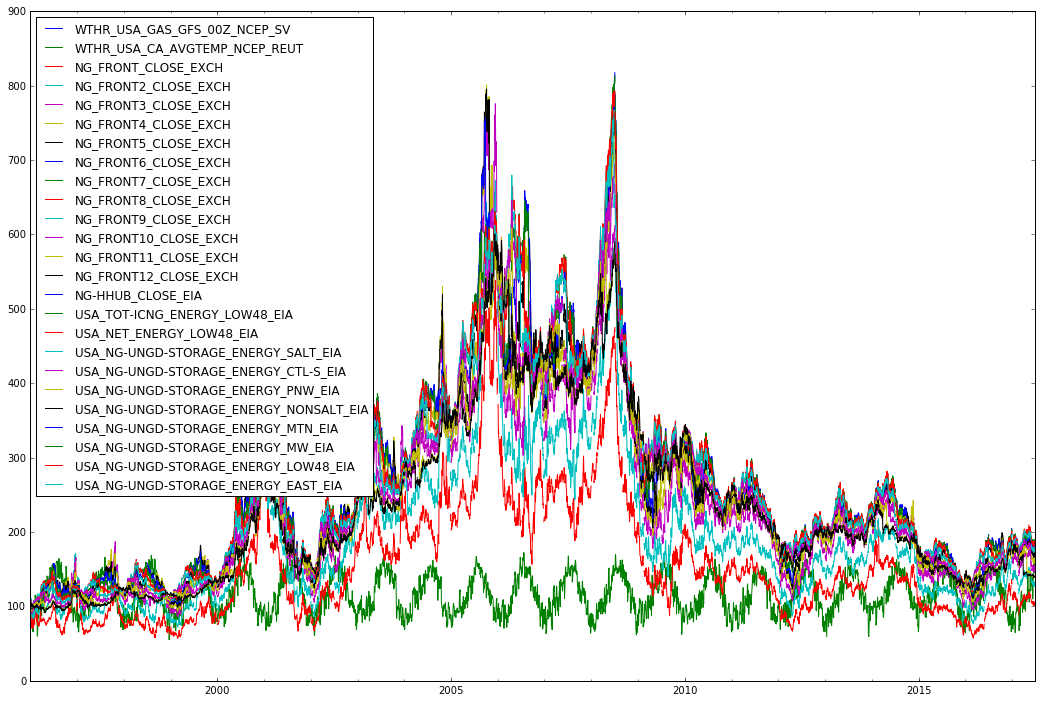

In [19]:
ax = df2.rebase().plot(figsize=(18,12)) #rebase makes them start at common date

In [23]:
df2_dropna = df2.dropna()
df2_dropna.head()

WTHR_USA_GAS_GFS_00Z_NCEP_SV  WTHR_USA_CA_AVGTEMP_NCEP_REUT  \
2016-09-02                        0.3545                          71.06   
2016-09-09                        0.5777                          73.76   
2016-09-16                        1.0658                          68.36   
2016-09-23                        1.1048                          58.64   
2016-09-30                        3.3586                          67.28   

            NG_FRONT_CLOSE_EXCH  NG_FRONT2_CLOSE_EXCH  NG_FRONT3_CLOSE_EXCH  \
2016-09-02                2.792                 2.898                 3.101   
2016-09-09                2.797                 2.890                 3.119   
2016-09-16                2.948                 3.021                 3.211   
2016-09-23                2.955                 3.013                 3.220   
2016-09-30                2.906                 3.132                 3.268   

            NG_FRONT4_CLOSE_EXCH  NG_FRONT5_CLOSE_EXCH  NG_FRONT6_CLOSE_EXCH  \
2016-09-02                 3.226                 3.234                 3.195   
2016-09-09                 3.243                 3.246                 3.205   
2016-09-16                 3.333                 3.338                 3.297   
2016-09-23                 3.341                 3.346                 3.300   
2016-09-30                 3.275                 3.230                 3.000   

            NG_FRONT7_CLOSE_EXCH  NG_FRONT8_CLOSE_EXCH  \
2016-09-02                 2.972                 2.948   
2016-09-09                 2.986                 2.963   
2016-09-16                 3.062                 3.034   
2016-09-23                 3.034                 2.996   
2016-09-30                 2.964                 2.994   

                           ...                   \
2016-09-02                 ...                    
2016-09-09                 ...                    
2016-09-16                 ...                    
2016-09-23                 ...                    
2016-09-30                 ...                    

            USA_TOT-ICNG_ENERGY_LOW48_EIA  USA_NET_ENERGY_LOW48_EIA  \
2016-09-02                   -8359.083333             482145.750000   
2016-09-09                   -5910.666667             537133.666667   
2016-09-16                 -160308.833333             476260.708333   
2016-09-23                   -5993.541667             486508.000000   
2016-09-30                   -5846.166667             424314.208333   

            USA_NG-UNGD-STORAGE_ENERGY_SALT_EIA  \
2016-09-02                                  280   
2016-09-09                                  285   
2016-09-16                                  278   
2016-09-23                                  275   
2016-09-30                                  289   

            USA_NG-UNGD-STORAGE_ENERGY_CTL-S_EIA  \
2016-09-02                                  1160   
2016-09-09                                  1169   
2016-09-16                                  1167   
2016-09-23                                  1161   
2016-09-30                                  1181   

            USA_NG-UNGD-STORAGE_ENERGY_PNW_EIA  \
2016-09-02                                 313   
2016-09-09                                 317   
2016-09-16                                 318   
2016-09-23                                 318   
2016-09-30                                 318   

            USA_NG-UNGD-STORAGE_ENERGY_NONSALT_EIA  \
2016-09-02                                     880   
2016-09-09                                     884   
2016-09-16                                     889   
2016-09-23                                     885   
2016-09-30                                     893   

            USA_NG-UNGD-STORAGE_ENERGY_MTN_EIA  \
2016-09-02                                 224   
2016-09-09                                 227   
2016-09-16                                 230   
2016-09-23                                 233   
2016-09-30                

In [26]:
cols2 = cols[1:]

In [27]:
df3 = df2.pct_change()
df3

WTHR_USA_GAS_GFS_00Z_NCEP_SV  WTHR_USA_CA_AVGTEMP_NCEP_REUT  \
1996-01-02                           NaN                            NaN   
1996-01-03                           NaN                      -0.035489   
1996-01-04                           NaN                      -0.044154   
1996-01-05                           NaN                      -0.026946   
1996-01-08                           NaN                       0.146374   
1996-01-09                           NaN                      -0.044862   
1996-01-10                           NaN                      -0.018065   
1996-01-11                           NaN                       0.044154   
1996-01-12                           NaN                       0.042287   
1996-01-15                           NaN                      -0.043952   
1996-01-16                           NaN                      -0.024754   
1996-01-17                           NaN                      -0.105157   
1996-01-18                           NaN                      -0.093201   
1996-01-19                           NaN                       0.084906   
1996-01-22                           NaN                      -0.189474   
1996-01-23                           NaN                      -0.055901   
1996-01-24                           NaN                       0.177632   
1996-01-25                           NaN                       0.022854   
1996-01-26                           NaN                      -0.084906   
1996-01-29                           NaN                       0.126967   
1996-01-30                           NaN                       0.082330   
1996-01-31                           NaN                       0.016014   
1996-02-01                           NaN                      -0.019702   
1996-02-02                           NaN                       0.000000   
1996-02-05                           NaN                       0.188924   
1996-02-06                           NaN                      -0.010143   
1996-02-07                           NaN                       0.068311   
1996-02-08                           NaN                       0.038366   
1996-02-09                           NaN                      -0.021553   
1996-02-12                           NaN                       0.009441   
...                                  ...                            ...   
2017-05-17                     -0.082051                       0.030123   
2017-05-18                      0.246042                       0.042238   
2017-05-19                      0.511816                       0.087288   
2017-05-22                     -0.118871                       0.154826   
2017-05-23                     -0.160947                       0.019862   
2017-05-24                      0.048129                      -0.026778   
2017-05-25                      0.111954                      -0.090050   
2017-05-26                     -0.355106                      -0.063225   
2017-05-29                     -0.093281                       0.129116   
2017-05-30                      0.237756                      -0.007797   
2017-05-31                     -0.382321                      -0.041909   
2017-06-01                     -0.415233                      -0.016403   
2017-06-02                     -0.084109                       0.058369   
2017-06-05                      0.065817                       0.028888   
2017-06-06                      1.130312                       0.000000   
2017-06-07                     -0.199169                      -0.017867   
2017-06-08                     -0.171692                      -0.046780   
2017-06-09                     -0.540844                      -0.032717   
2017-06-12                      0.735312                      -0.126840   
2017-06-13                     -0.208758                       0.090387   
2017-06-14                     -0.504748                       0.103618   
2017-06-15                     -0.201

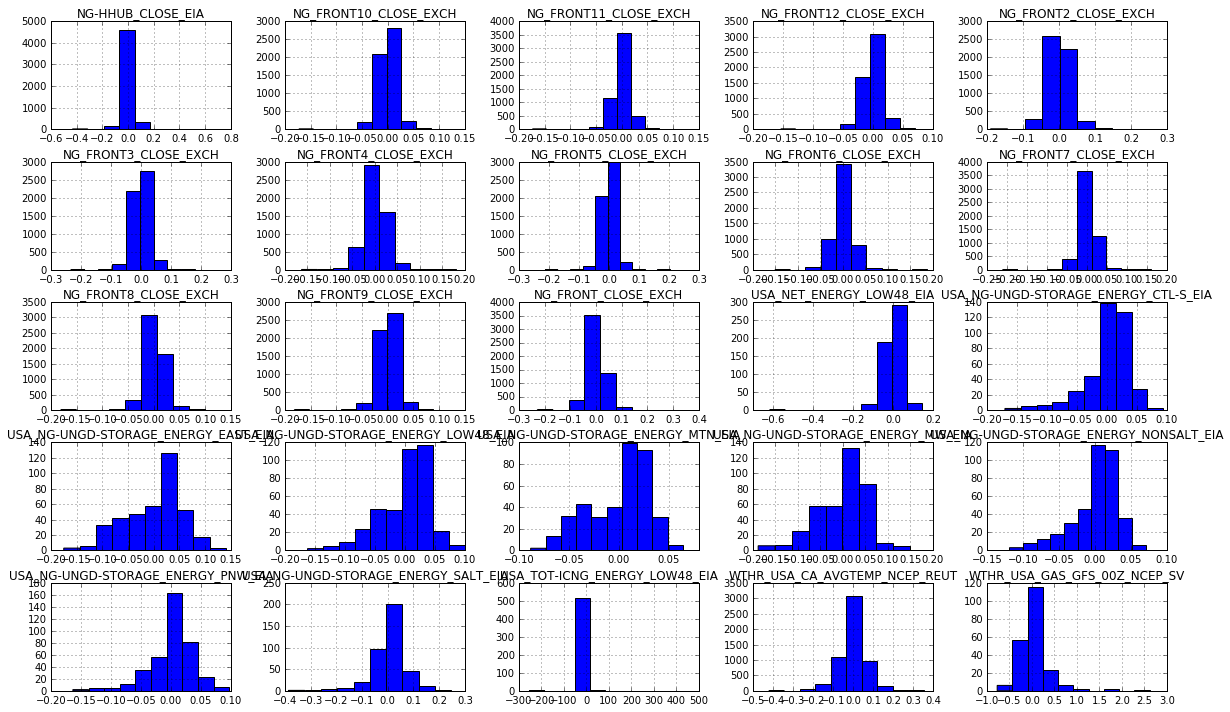

In [28]:
percent_change = df3
ax2 = percent_change.hist(figsize=(20,12))

In [ ]:
#display statistics

In [54]:
#half of display statistics
col4 = cols[3:7]
blah2 = df2[col4]
#.calc_stats()
#stats.display()
blah2 = pd.DataFrame(blah2)
blah2 = blah2.dropna()
stats_ngfront = blah2.calc_stats()
stats_ngfront.display()

Stat                 NG_FRONT_CLOSE_EXCH    NG_FRONT2_CLOSE_EXCH    NG_FRONT3_CLOSE_EXCH    NG_FRONT4_CLOSE_EXCH
-------------------  ---------------------  ----------------------  ----------------------  ----------------------
Start                1996-01-02             1996-01-02              1996-01-02              1996-01-02
End                  2017-06-27             2017-06-27              2017-06-27              2017-06-27
Risk-free rate       0.00%                  0.00%                   0.00%                   0.00%

Total Return         5.74%                  33.03%                  54.54%                  65.29%
Daily Sharpe         0.28                   0.27                    0.27                    0.26
CAGR                 0.26%                  1.34%                   2.05%                   2.37%
Max Drawdown         -89.34%                -88.55%                 -87.70%                 -86.75%

MTD                  -1.56%                 -1.80%                  -1.5

In [57]:
#other half of display statistics
col5 = cols[7:11]
blah3 = df2[col5]
#.calc_stats()
#stats.display()
blah3 = pd.DataFrame(blah3)
blah3 = blah3.dropna()
stats_ngfront2 = blah3.calc_stats()
stats_ngfront2.display()

Stat                 NG_FRONT5_CLOSE_EXCH    NG_FRONT6_CLOSE_EXCH    NG_FRONT7_CLOSE_EXCH    NG_FRONT8_CLOSE_EXCH
-------------------  ----------------------  ----------------------  ----------------------  ----------------------
Start                1996-01-02              1996-01-02              1996-01-02              1996-01-02
End                  2017-06-27              2017-06-27              2017-06-27              2017-06-27
Risk-free rate       0.00%                   0.00%                   0.00%                   0.00%

Total Return         73.22%                  85.14%                  89.92%                  87.91%
Daily Sharpe         0.25                    0.25                    0.25                    0.25
CAGR                 2.59%                   2.91%                   3.03%                   2.98%
Max Drawdown         -85.95%                 -85.92%                 -85.55%                 -84.89%

MTD                  -1.48%                  -0.87%            

In [61]:
col6 = cols[11:15]
blah4 = df2[col6]
blah4 = pd.DataFrame(blah4)
blah4 = blah4.dropna()
stats_ngfront3 = blah4.calc_stats()
stats_ngfront3.display()

Stat                 NG_FRONT9_CLOSE_EXCH    NG_FRONT10_CLOSE_EXCH    NG_FRONT11_CLOSE_EXCH    NG_FRONT12_CLOSE_EXCH
-------------------  ----------------------  -----------------------  -----------------------  -----------------------
Start                1996-01-02              1996-01-02               1996-01-02               1996-01-02
End                  2017-06-27              2017-06-27               2017-06-27               2017-06-27
Risk-free rate       0.00%                   0.00%                    0.00%                    0.00%

Total Return         78.81%                  48.52%                   40.23%                   40.71%
Daily Sharpe         0.24                    0.21                     0.20                     0.19
CAGR                 2.74%                   1.86%                    1.59%                    1.60%
Max Drawdown         -83.86%                 -81.91%                  -80.58%                  -79.46%

MTD                  -0.91%                

In [68]:
col7 = cols[15:16]
blah5 = df2[col7]
blah5 = pd.DataFrame(blah5)
blah5 = blah5.dropna()
stats_ngfront4 = blah5.calc_stats()
stats_ngfront4.display()

Stat                 NG-HHUB_CLOSE_EIA
-------------------  -------------------
Start                1997-01-07
End                  2017-06-19
Risk-free rate       0.00%

Total Return         -24.87%
Daily Sharpe         0.33
CAGR                 -1.39%
Max Drawdown         -91.94%

MTD                  -5.90%
3m                   0.70%
6m                   -19.15%
YTD                  -22.64%
1Y                   10.81%
3Y (ann.)            -14.98%
5Y (ann.)            2.07%
10Y (ann.)           -9.11%
Since Incep. (ann.)  -1.39%

Daily Sharpe         0.33
Daily Mean (ann.)    23.51%
Daily Vol (ann.)     72.04%
Daily Skew           2.19
Daily Kurt           32.81
Best Day             78.01%
Worst Day            -43.34%

Monthly Sharpe       0.31
Monthly Mean (ann.)  20.35%
Monthly Vol (ann.)   65.89%
Monthly Skew         1.11
Monthly Kurt         4.14
Best Month           93.73%
Worst Month          -53.65%

Yearly Sharpe        0.23
Yearly Mean          20.04%
Yearly Vol           8

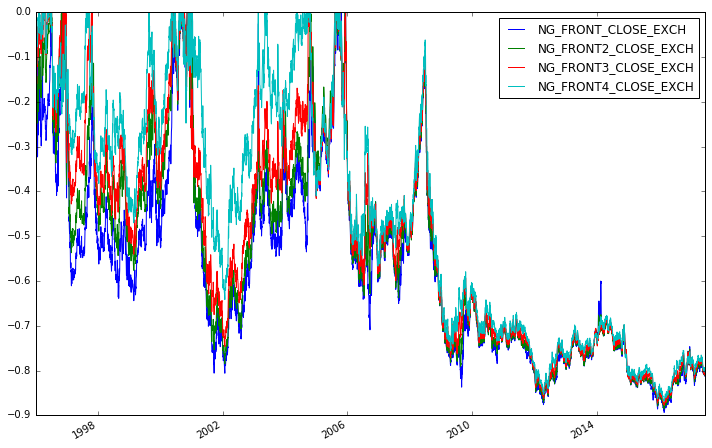

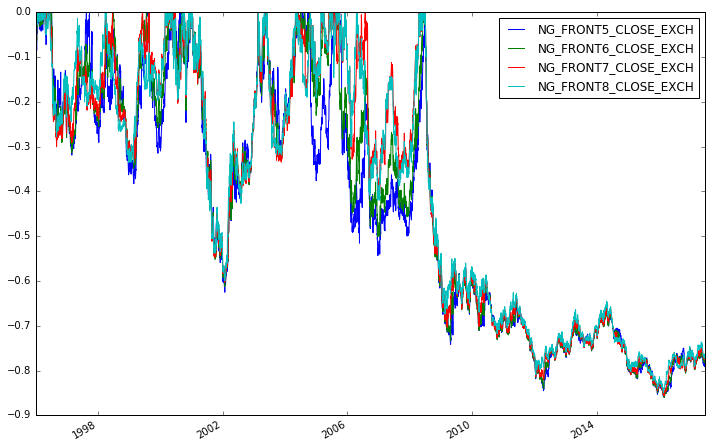

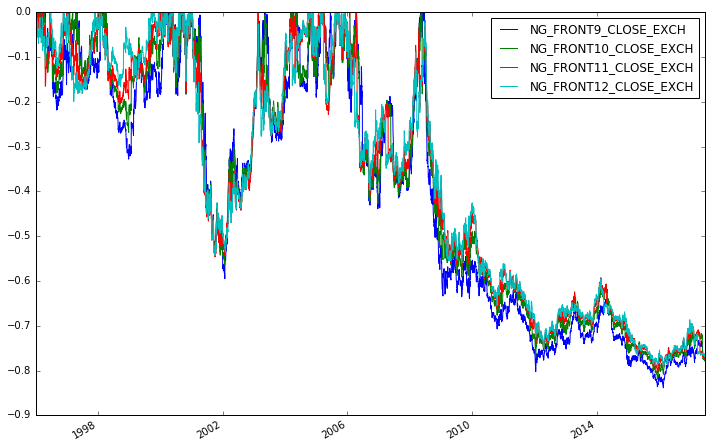

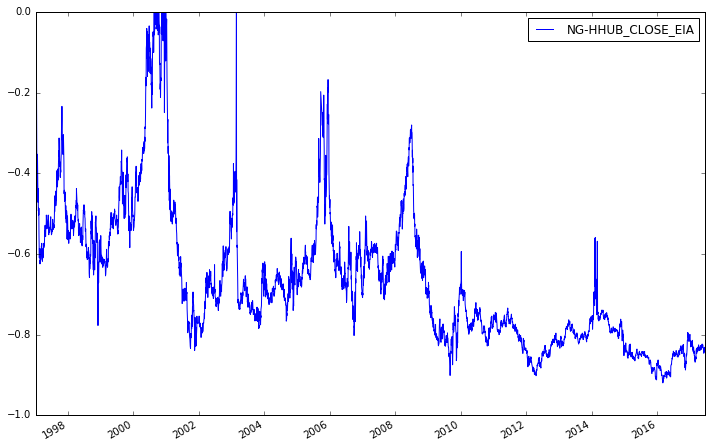

In [97]:
#drawdown graphs
ax4 = stats_ngfront.prices.to_drawdown_series().plot(figsize=(12,8))
ax5 = stats_ngfront2.prices.to_drawdown_series().plot(figsize=(12,8))
ax6 = stats_ngfront3.prices.to_drawdown_series().plot(figsize=(12,8))
ax7 = stats_ngfront4.prices.to_drawdown_series().plot(figsize=(12,8))


0.688


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000151074A8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000177854E0>], dtype=object)

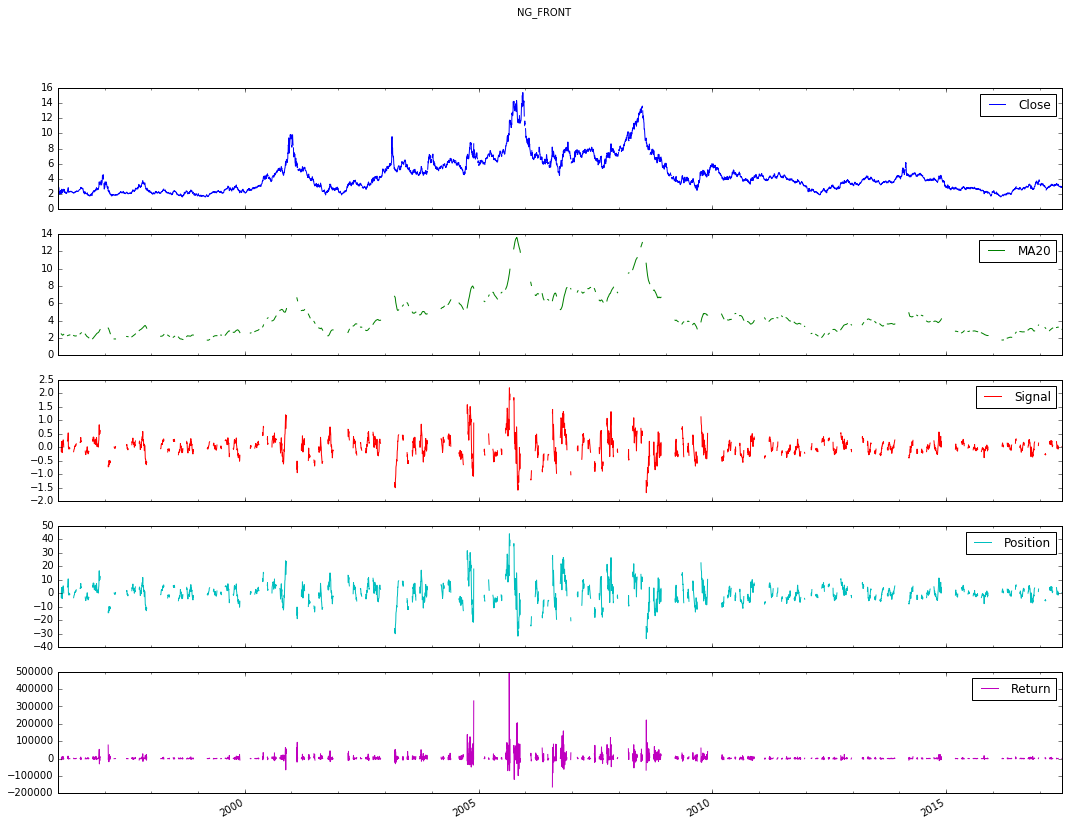

In [108]:
#individual front1
df_NGFront1 = df2[cols[3]]
df_NGFront1 = pd.DataFrame(df_NGFront1)
df_NGFront1.columns = ['Close']
df_NGFront1['MA20'] = pd.rolling_mean(df_NGFront1['Close'],20)
df_NGFront1['Signal'] = df_NGFront1['Close'] - df_NGFront1['MA20']
df_NGFront1['Position'] = df_NGFront1['Signal'] * 20.
df_NGFront1['Return'] = df_NGFront1['Close'].diff() * df_NGFront1['Position'] * 10000.

print(df_NGFront1['Position'][-1])
df_NGFront1.plot(subplots=True, figsize=(18,14),title = 'NG_FRONT')
#second chart smooths, 3rd chart not simply a value where 1 represents a buy, 0 as liquidate,
#and -1 to go short. In this chart we have to multiply the signal value by a multiple to generate the Position.
#(Not the best position sizing technique by a long shot but this is a toy strategy.)
#4th represents #lots held, 5th is daily returns

-3.31


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001812F0F0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000019BF3898>], dtype=object)

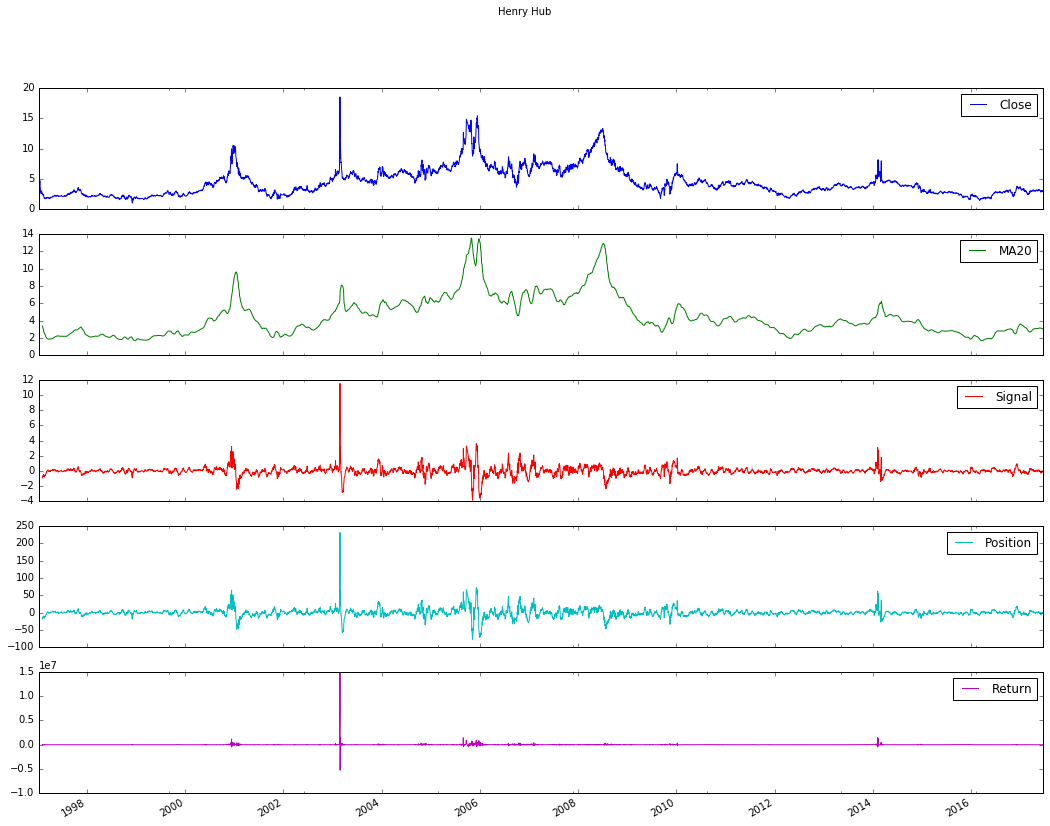

In [113]:
#individual front1
df_HHUB = df2[cols[15]]
df_HHUB = pd.DataFrame(df_HHUB)
df_HHUB = df_HHUB.dropna()
df_HHUB.columns = ['Close']
df_HHUB['MA20'] = pd.rolling_mean(df_HHUB['Close'],20)
df_HHUB['Signal'] = df_HHUB['Close'] - df_HHUB['MA20']
df_HHUB['Position'] = df_HHUB['Signal'] * 20.
df_HHUB['Return'] = df_HHUB['Close'].diff() * df_HHUB['Position'] * 10000.

print(df_HHUB['Position'][-1])
df_HHUB.plot(subplots=True, figsize=(18,14),title = 'Henry Hub')

In [115]:
#now includes slippage, commission and other liquidity
df_NGFront1n = df2[cols[3]]
df_NGFront1n = pd.DataFrame(df_NGFront1n)
df_NGFront1n.columns = ['Close']
df_NGFront1n['MA20'] = pd.rolling_mean(df_NGFront1n['Close'],20, min_periods=10) #can carry on if missing data
df_NGFront1n['Signal'] = df_NGFront1n['Close'] - df_NGFront1n['MA20']
df_NGFront1n['NextPosition'] = (df_NGFront1n['Signal'] *20).clip(-5., +5.).round() #can only hold an integer number of contracts
df_NGFront1n['Position'] = df_NGFront1n['NextPosition'].shift(1) #look ahead bias, basing signals on the current day’s closing price,need to lag the data
df_NGFront1n['Trade'] = df_NGFront1n['NextPosition'] - df_NGFront1n['Position']
df_NGFront1n['Costs'] = df_NGFront1n['Trade'].abs() * 100.
df_NGFront1n['Return'] = (df_NGFront1n['Close'].diff() * df_NGFront1n['Position'] * 10000.) - df_NGFront1n['Costs']

print(df_NGFront1n.tail())

            Close      MA20    Signal  NextPosition  Position  Trade  Costs  \
2017-06-21  2.893  3.027474 -0.134474            -3        -3      0      0   
2017-06-22  2.894  3.012211 -0.118211            -2        -3      1    100   
2017-06-23  2.929  2.993000 -0.064000            -1        -2      1    100   
2017-06-26  3.027  2.994700  0.032300             1        -1      2    200   
2017-06-27  3.023  2.988600  0.034400             1         1      0      0   

            Return  
2017-06-21     420  
2017-06-22    -130  
2017-06-23    -800  
2017-06-26   -1180  
2017-06-27     -40  


In [117]:
df_HHUBn = df2[cols[15]]
df_HHUBn = pd.DataFrame(df_HHUBn)
df_HHUBn.columns = ['Close']
df_HHUBn = df_HHUBn.dropna()
df_HHUBn['MA20'] = pd.rolling_mean(df_HHUBn['Close'],20, min_periods=10) #can carry on if missing data
df_HHUBn['Signal'] = df_HHUBn['Close'] - df_HHUBn['MA20']
df_HHUBn['NextPosition'] = (df_HHUBn['Signal'] *20).clip(-5., +5.).round() #can only hold an integer number of contracts
df_HHUBn['Position'] = df_HHUBn['NextPosition'].shift(1) #look ahead bias, basing signals on the current day’s closing price,need to lag the data
df_HHUBn['Trade'] = df_HHUBn['NextPosition'] - df_HHUBn['Position']
df_HHUBn['Costs'] = df_HHUBn['Trade'].abs() * 100.
df_HHUBn['Return'] = (df_HHUBn['Close'].diff() * df_HHUBn['Position'] * 10000.) - df_HHUBn['Costs']

print(df_HHUBn.tail())

            Close    MA20  Signal  NextPosition  Position  Trade  Costs  \
2017-06-13   3.12  3.0845  0.0355             1         1      0      0   
2017-06-14   2.95  3.0685 -0.1185            -2         1     -3    300   
2017-06-15   2.94  3.0590 -0.1190            -2        -2      0      0   
2017-06-16   3.01  3.0540 -0.0440            -1        -2      1    100   
2017-06-19   2.87  3.0355 -0.1655            -3        -1     -2    200   

            Return  
2017-06-13       0  
2017-06-14   -2000  
2017-06-15     200  
2017-06-16   -1500  
2017-06-19    1200  


In [163]:
#let's make it so we are looking at past 5 years of data, July 2012 - June 2017
df_5yr = df2[4304:]
df_5yr.head()

WTHR_USA_GAS_GFS_00Z_NCEP_SV  WTHR_USA_CA_AVGTEMP_NCEP_REUT  \
2012-07-02                           NaN                          71.42   
2012-07-03                           NaN                          70.88   
2012-07-04                           NaN                          70.70   
2012-07-05                           NaN                          69.08   
2012-07-06                           NaN                          70.16   

            NG_FRONT_CLOSE_EXCH  NG_FRONT2_CLOSE_EXCH  NG_FRONT3_CLOSE_EXCH  \
2012-07-02                2.824                 2.832                 2.877   
2012-07-03                2.899                 2.911                 2.955   
2012-07-04                  NaN                   NaN                   NaN   
2012-07-05                2.945                 2.950                 2.990   
2012-07-06                2.776                 2.786                 2.825   

            NG_FRONT4_CLOSE_EXCH  NG_FRONT5_CLOSE_EXCH  NG_FRONT6_CLOSE_EXCH  \
2012-07-02                 3.100                 3.362                 3.503   
2012-07-03                 3.177                 3.429                 3.566   
2012-07-04                   NaN                   NaN                   NaN   
2012-07-05                 3.209                 3.448                 3.583   
2012-07-06                 3.051                 3.299                 3.440   

            NG_FRONT7_CLOSE_EXCH  NG_FRONT8_CLOSE_EXCH  \
2012-07-02                 3.512                 3.483   
2012-07-03                 3.575                 3.544   
2012-07-04                   NaN                   NaN   
2012-07-05                 3.593                 3.563   
2012-07-06                 3.454                 3.431   

                           ...                   \
2012-07-02                 ...                    
2012-07-03                 ...                    
2012-07-04                 ...                    
2012-07-05                 ...                    
2012-07-06                 ...                    

            USA_TOT-ICNG_ENERGY_LOW48_EIA  USA_NET_ENERGY_LOW48_EIA  \
2012-07-02                            NaN                       NaN   
2012-07-03                            NaN                       NaN   
2012-07-04                            NaN                       NaN   
2012-07-05                            NaN                       NaN   
2012-07-06                            NaN                       NaN   

            USA_NG-UNGD-STORAGE_ENERGY_SALT_EIA  \
2012-07-02                                  NaN   
2012-07-03                                  NaN   
2012-07-04                                  NaN   
2012-07-05                                  NaN   
2012-07-06                                  251   

            USA_NG-UNGD-STORAGE_ENERGY_CTL-S_EIA  \
2012-07-02                                   NaN   
2012-07-03                                   NaN   
2012-07-04                                   NaN   
2012-07-05                                   NaN   
2012-07-06                                  1079   

            USA_NG-UNGD-STORAGE_ENERGY_PNW_EIA  \
2012-07-02                                 NaN   
2012-07-03                                 NaN   
2012-07-04                                 NaN   
2012-07-05                                 NaN   
2012-07-06                                 360   

            USA_NG-UNGD-STORAGE_ENERGY_NONSALT_EIA  \
2012-07-02                                     NaN   
2012-07-03                                     NaN   
2012-07-04                                     NaN   
2012-07-05                                     NaN   
2012-07-06                                     828   

            USA_NG-UNGD-STORAGE_ENERGY_MTN_EIA  \
2012-07-02                                 NaN   
2012-07-03                                 NaN   
2012-07-04                                 NaN   
2012-07-05                                 NaN   
2012-07-06                

In [131]:
#df_5yr = df2[4304:]
storage_cols = cols[18:]
df_5yr_storage = df_5yr[storage_cols].dropna()


USA_NG-UNGD-STORAGE_ENERGY_SALT_EIA  \
2012-07-06                                  251   
2012-07-13                                  247   
2012-07-20                                  242   
2012-07-27                                  234   
2012-08-03                                  226   
2012-08-10                                  220   
2012-08-17                                  218   
2012-08-24                                  227   
2012-08-31                                  221   
2012-09-07                                  207   
2012-09-14                                  217   
2012-09-21                                  232   
2012-09-28                                  245   
2012-10-05                                  260   
2012-10-12                                  271   
2012-10-19                                  286   
2012-10-26                                  300   
2012-11-02                                  307   
2012-11-09                                  310   
2012-11-16                                  311   
2012-11-23                                  317   
2012-11-30                                  316   
2012-12-07                                  320   
2012-12-14                                  312   
2012-12-21                                  310   
2012-12-28                                  302   
2013-01-04                                  283   
2013-01-11                                  275   
2013-01-18                                  260   
2013-01-25                                  244   
...                                         ...   
2016-11-25                                  400   
2016-12-02                                  403   
2016-12-09                                  388   
2016-12-16                                  363   
2016-12-23                                  324   
2016-12-30                                  343   
2017-01-06                                  343   
2017-01-13                                  312   
2017-01-20                                  325   
2017-01-27                                  340   
2017-02-03                                  338   
2017-02-10                                  332   
2017-02-17                                  328   
2017-02-24                                  333   
2017-03-03                                  326   
2017-03-10                                  325   
2017-03-17                                  295   
2017-03-24                                  289   
2017-03-31                                  295   
2017-04-07                                  301   
2017-04-14                                  314   
2017-04-21                                  321   
2017-04-28                                  329   
2017-05-05                                  331   
2017-05-12                                  337   
2017-05-19                                  338   
2017-05-26                                  342   
2017-06-02                                  345   
2017-06-09                                  348   
2017-06-16                                  343   

            USA_NG-UNGD-STORAGE_ENERGY_CTL-S_EIA  \
2012-07-06                                  1079   
2012-07-13                                  1080   
2012-07-20                                  1079   
2012-07-27                                  1073   
2012-08-03                                  1067   
2012-08-10                                  1063   
2012-08-17                                  1068   
2012-08-24                                  1084   
2012-08-31                                  1077   
2012-09-07                                  1062   
2012-09-14                                  1082   
2012-09-21                                  1111   
2012-09-28                                  1137   
2012-10-05                                  1164   
2012-10-12                                  1182   
2012-10-19       

In [133]:
#add national avg by taking avg of all those locations
df_5yr_storage['All_Region'] = df_5yr_storage.mean()
df_5yr_storage.columns

Index(['USA_NG-UNGD-STORAGE_ENERGY_SALT_EIA',
       'USA_NG-UNGD-STORAGE_ENERGY_CTL-S_EIA',
       'USA_NG-UNGD-STORAGE_ENERGY_PNW_EIA',
       'USA_NG-UNGD-STORAGE_ENERGY_NONSALT_EIA',
       'USA_NG-UNGD-STORAGE_ENERGY_MTN_EIA',
       'USA_NG-UNGD-STORAGE_ENERGY_MW_EIA',
       'USA_NG-UNGD-STORAGE_ENERGY_LOW48_EIA',
       'USA_NG-UNGD-STORAGE_ENERGY_EAST_EIA', 'All_Region'],
      dtype='object')

In [138]:
df_5yr_storage_monthly = df_5yr_storage.groupby(df_5yr_storage.index.month).mean()
df_5yr_storage_monthly['All_Region'] = df_5yr_storage_monthly.sum(axis=1)
df_5yr_storage_monthly

USA_NG-UNGD-STORAGE_ENERGY_SALT_EIA  USA_NG-UNGD-STORAGE_ENERGY_CTL-S_EIA  \
1                            281.347826                           1007.913043   
2                            227.100000                            830.250000   
3                            197.727273                            733.454545   
4                            226.857143                            779.428571   
5                            258.869565                            855.260870   
6                            286.473684                            967.789474   
7                            276.727273                           1023.000000   
8                            253.391304                           1017.782609   
9                            262.761905                           1076.857143   
10                           313.090909                           1186.636364   
11                           342.818182                           1254.090909   
12                           333.285714                           1190.714286   

    USA_NG-UNGD-STORAGE_ENERGY_PNW_EIA  \
1                           270.217391   
2                           228.450000   
3                           217.272727   
4                           232.619048   
5                           258.869565   
6                           294.000000   
7                           322.909091   
8                           331.608696   
9                           336.142857   
10                          353.500000   
11                          362.772727   
12                          329.857143   

    USA_NG-UNGD-STORAGE_ENERGY_NONSALT_EIA  \
1                               726.478261   
2                               603.150000   
3                               535.818182   
4                               552.666667   
5                               596.304348   
6                               681.157895   
7                               746.181818   
8                               764.434783   
9                               814.047619   
10                              873.545455   
11                              911.272727   
12                              857.380952   

    USA_NG-UNGD-STORAGE_ENERGY_MTN_EIA  USA_NG-UNGD-STORAGE_ENERGY_MW_EIA  \
1                           163.826087                         756.565217   
2                           138.300000                         540.300000   
3                           124.818182                         399.636364   
4                           124.904762                         371.619048   
5                           131.608696                         428.130435   
6                           152.894737                         555.210526   
7                           170.772727                         687.181818   
8                           182.086957                         796.608696   
9                           200.714286                         933.333333   
10                          212.454545                        1048.136364   
11                          219.045455                        1083.909091   
12                          201.952381                         973.142857   

    USA_NG-UNGD-STORAGE_ENERGY_LOW48_EIA  USA_NG-UNGD-STORAGE_ENERGY_EAST_EIA  \
1                            2857.869565                           659.521739   
2                            2200.050000                           462.850000   
3                            1800.181818                           325.045455   
4                            1811.619048                           303.238095   
5                            2062.956522                           389.173913   
6                            2486.105263                           516.315789   
7                            2852.772727                           648.863636   
8                            3059.043478                           730.913043   
9                            3366.666667                           819.61

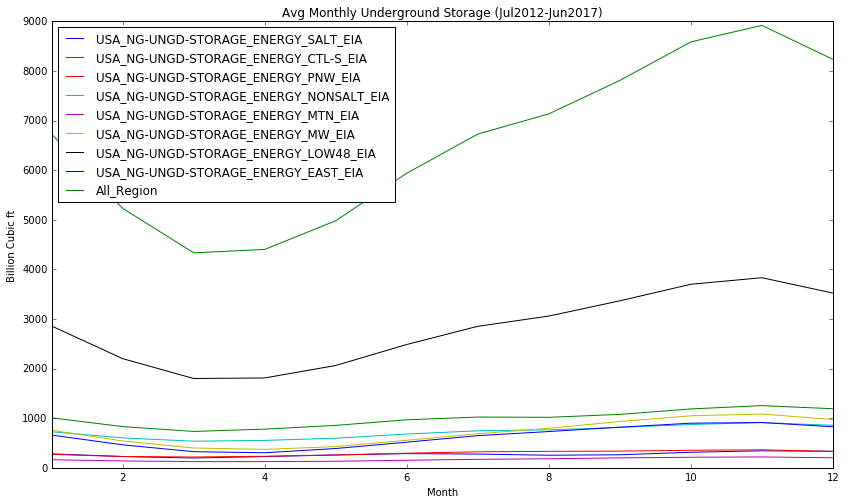

In [150]:
ax_monthly_storage = df_5yr_storage_monthly.plot(figsize=(14,8),title = "Avg Monthly Underground Storage (Jul2012-Jun2017)")
ax_monthly_storage.set_ylabel("Billion Cubic ft")
ax_monthly_storage.set_xlabel("Month")

In [159]:
gas_price_cols = cols[3:16]
df_5yr_gas = df_5yr[gas_price_cols]


NG_FRONT_CLOSE_EXCH  NG_FRONT2_CLOSE_EXCH  NG_FRONT3_CLOSE_EXCH  \
2012-07-02                2.824                 2.832                 2.877   
2012-07-03                2.899                 2.911                 2.955   

            NG_FRONT4_CLOSE_EXCH  NG_FRONT5_CLOSE_EXCH  NG_FRONT6_CLOSE_EXCH  \
2012-07-02                 3.100                 3.362                 3.503   
2012-07-03                 3.177                 3.429                 3.566   

            NG_FRONT7_CLOSE_EXCH  NG_FRONT8_CLOSE_EXCH  NG_FRONT9_CLOSE_EXCH  \
2012-07-02                 3.512                 3.483                 3.450   
2012-07-03                 3.575                 3.544                 3.508   

            NG_FRONT10_CLOSE_EXCH  NG_FRONT11_CLOSE_EXCH  \
2012-07-02                  3.477                  3.511   
2012-07-03                  3.533                  3.566   

            NG_FRONT12_CLOSE_EXCH  NG-HHUB_CLOSE_EIA  
2012-07-02                  3.557               2.73  
2012-07-03                  3.613               2.78

In [182]:
from PredictValues import *

x_dict = {}
for i in range(0,1):
    x_dict[i] = getForecastTable("NG","20170628", "EXCH", "CLOSE")

dfnew = pd.DataFrame(x_dict)
dfnew.columns = ['Nat Gas']
df_5yr_past = df_5yr[cols[15]]
df_5yr_past = pd.DataFrame(df_5yr_past)
past_future = df_5yr_past.append(df_new)

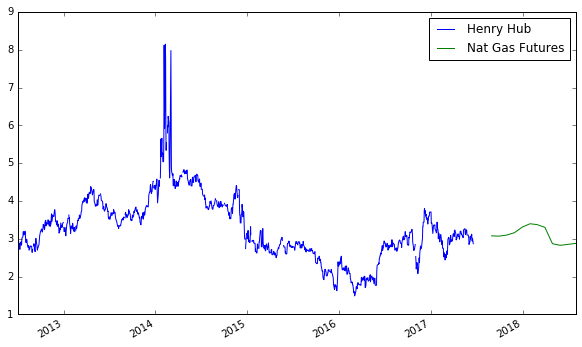

In [184]:
ax_past_future = past_future.plot(figsize=(10,6))
ax_past_future.legend(['Henry Hub','Nat Gas Futures'])

In [158]:
import datetime
ticker = ['NG_FRONT','NG_FRONT2','NG_FRONT3','NG_FRONT4','NG_FRONT5','NG_FRONT6','NG_FRONT7',
          'NG_FRONT8','NG_FRONT9','NG_FRONT10','NG_FRONT11','NG_FRONT12','NG_FRONT','NG_FRONT2','NG_FRONT3','NG_FRONT4','NG_FRONT5','NG_FRONT6','NG_FRONT7',
          'NG_FRONT8','NG_FRONT9','NG_FRONT10','NG_FRONT11','NG_FRONT12','NG-HHUB'] 
field_name = ['CLOSE','CLOSE','CLOSE','CLOSE','CLOSE','CLOSE','CLOSE','CLOSE','CLOSE','CLOSE',
             'CLOSE','CLOSE','CONTRACTMONTH','CONTRACTMONTH','CONTRACTMONTH','CONTRACTMONTH','CONTRACTMONTH',
              'CONTRACTMONTH','CONTRACTMONTH','CONTRACTMONTH','CONTRACTMONTH','CONTRACTMONTH','CONTRACTMONTH',
              'CONTRACTMONTH','CLOSE']
source = ['EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH',
          'EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EIA']

#print(len(ticker))
#print(len(field_name))
#print(len(source))
start_date = '01/02/1996'
end_date = '06/27/2017'
cal_type = 'WD'

crtConn = crtDbOpen()
df = pd.DataFrame()
whole_dataframes = {}
    
for i in range(0,len(ticker)):
            
    period_series_dict = {}                    
    statement ="Select * FROM dbo.CRTGetPeriodSeries('" + start_date + "' , '" + end_date + "' , '" + ticker[i] + "' , '" + field_name[i] + "' , '" + source[i] + "','" + cal_type + "')"
    get_period_series_list = crt_gen_sel (crtConn, statement, None,case="same")
        
    for row in get_period_series_list:
        dt = str(row[0])
        tmpDate = dt.split(' ')
        dt = tmpDate[0]           
        dt = datetime.datetime.strptime(dt,'%Y-%m-%d')
        t_year = dt.year            
        dbDate = str(dt).split(' ')
        dbDate = dbDate[0]
        dbDate = str(dbDate[:len(dbDate)-2] + str(t_year))           
        period_series_dict[dt] = row[1]
            
    statement = " TICKER like '" + ticker[i] + "' AND FIELDNAME = '" + field_name[i] + "' AND DATASOURCE = '" + source[i] + "'"
    TableName = 'CRTTICKERNAME'
    IdColName = 'tickerid'            
    get_id = crt_select_multiple_value(crtConn,TableName, IdColName, statement)            
    statement = " tickerid = " + get_id.get(1)
    statement = statement.replace(',','')
    statement = statement.strip()            
    TableName = 'CRTTICKERVALUE'
    IdColName = 'tickerValueDate,tickerValue'
    PP = crt_select_multiple_value(crtConn,TableName, IdColName, statement)        
    date_list = []
    value_list = []
            
    for key, value in iter(PP.items()):
        temp_value = PP.get(key)
        temp_value = temp_value.split(',')        
        dbValue = float(temp_value[1])
        dbDate = str(temp_value[0])
        dbDate = dbDate.split(' ')
        dbDate = dbDate[0]        
        tmpDate = datetime.datetime.strptime(dbDate,'%Y-%m-%d')               
        t_year = tmpDate.year                
        dbDate = str(dbDate[:len(dbDate)-2] + str(t_year))
                
        if period_series_dict.get(tmpDate):
            period_series_dict[tmpDate] = dbValue
        
    date_list = []
    value_list = [] 
    for key in sorted(period_series_dict.keys()):                
        dbDate = key
        dbValue = period_series_dict.get(key)                
        date_list.append(dbDate)
        value_list.append(dbValue)
        whole_dataframes[i] =  pd.DataFrame()
        
    s_PP = pd.Series(date_list)
    s_PP2 = pd.Series(value_list)
           
    whole_dataframes[i]['Date'] = s_PP
    whole_dataframes[i]['Date'] = pd.to_datetime(whole_dataframes[i]['Date']) #run
    whole_dataframes[i][ticker[i]+'_'+field_name[i]+'_'+source[i]] = s_PP2
            
whole_dataframes[0].index = whole_dataframes[0]['Date'].values  
whole_dataframes[0] = whole_dataframes[0].drop(['Date'],axis=1)
          
for i in range(1,len(ticker)):
    whole_dataframes[i].index = whole_dataframes[i]['Date'].values
    whole_dataframes[i] = whole_dataframes[i].drop(['Date'],axis=1)            
    whole_dataframes[0] = whole_dataframes[0].join(whole_dataframes[i])
df = whole_dataframes[0]

#df = df.dropna()
#df = df.fillna(df.mean())
date = df.index
dateList = []       
for tmp in date:
    tmpDate = str(tmp)  
    t_year = tmp.year
    t_month = tmp.month
    t_day = tmp.day          
    strDate = str(t_month) + '/' + str(t_day) + '/' + str(t_year)    
    dateList.append(strDate)
       
df['Date'] = dateList
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_price = df[cols]
df_price.head(1)

Date  NG_FRONT_CLOSE_EXCH  NG_FRONT2_CLOSE_EXCH  \
1996-01-02  1/2/1996                2.859                 2.295   

            NG_FRONT3_CLOSE_EXCH  NG_FRONT4_CLOSE_EXCH  NG_FRONT5_CLOSE_EXCH  \
1996-01-02                 1.971                 1.861                 1.811   

            NG_FRONT6_CLOSE_EXCH  NG_FRONT7_CLOSE_EXCH  NG_FRONT8_CLOSE_EXCH  \
1996-01-02                 1.776                 1.776                 1.786   

            NG_FRONT9_CLOSE_EXCH        ...          \
1996-01-02                 1.836        ...           

            NG_FRONT4_CONTRACTMONTH_EXCH  NG_FRONT5_CONTRACTMONTH_EXCH  \
1996-01-02                        199605                        199606   

            NG_FRONT6_CONTRACTMONTH_EXCH  NG_FRONT7_CONTRACTMONTH_EXCH  \
1996-01-02                        199607                        199608   

            NG_FRONT8_CONTRACTMONTH_EXCH  NG_FRONT9_CONTRACTMONTH_EXCH  \
1996-01-02                        199609                        199610   

            NG_FRONT10_CONTRACTMONTH_EXCH  NG_FRONT11_CONTRACTMONTH_EXCH  \
1996-01-02                         199611                         199612   

            NG_FRONT12_CONTRACTMONTH_EXCH  NG-HHUB_CLOSE_EIA  
1996-01-02                         199701                NaN  

[1 rows x 26 columns]

In [159]:
df_price_5yr = df_price.drop('Date',axis=1)
df_price_5yr = df_price_5yr[4304:]
cols2 = df_price_5yr.columns
contractmonth_cols = cols2[12:24]
df_contract_month = df_price_5yr[contractmonth_cols]
df_contract_month = df_contract_month.dropna()

In [81]:
df_contract_month['NG_FRONT_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT_CONTRACTMONTH_EXCH'].astype('int')
df_contract_month['NG_FRONT2_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT2_CONTRACTMONTH_EXCH'].astype('int')
df_contract_month['NG_FRONT3_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT3_CONTRACTMONTH_EXCH'].astype('int')
df_contract_month['NG_FRONT4_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT4_CONTRACTMONTH_EXCH'].astype('int')
df_contract_month['NG_FRONT5_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT5_CONTRACTMONTH_EXCH'].astype('int')
df_contract_month['NG_FRONT6_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT6_CONTRACTMONTH_EXCH'].astype('int')
df_contract_month['NG_FRONT7_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT7_CONTRACTMONTH_EXCH'].astype('int')
df_contract_month['NG_FRONT8_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT8_CONTRACTMONTH_EXCH'].astype('int')
df_contract_month['NG_FRONT9_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT9_CONTRACTMONTH_EXCH'].astype('int')
df_contract_month['NG_FRONT10_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT10_CONTRACTMONTH_EXCH'].astype('int')
df_contract_month['NG_FRONT11_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT11_CONTRACTMONTH_EXCH'].astype('int')
df_contract_month['NG_FRONT12_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT12_CONTRACTMONTH_EXCH'].astype('int')

In [82]:
df_contract_month['NG_FRONT_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT_CONTRACTMONTH_EXCH'].astype('str')
df_contract_month['NG_FRONT2_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT2_CONTRACTMONTH_EXCH'].astype('str')
df_contract_month['NG_FRONT3_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT3_CONTRACTMONTH_EXCH'].astype('str')
df_contract_month['NG_FRONT4_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT4_CONTRACTMONTH_EXCH'].astype('str')
df_contract_month['NG_FRONT5_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT5_CONTRACTMONTH_EXCH'].astype('str')
df_contract_month['NG_FRONT6_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT6_CONTRACTMONTH_EXCH'].astype('str')
df_contract_month['NG_FRONT7_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT7_CONTRACTMONTH_EXCH'].astype('str')
df_contract_month['NG_FRONT8_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT8_CONTRACTMONTH_EXCH'].astype('str')
df_contract_month['NG_FRONT9_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT9_CONTRACTMONTH_EXCH'].astype('str')
df_contract_month['NG_FRONT10_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT10_CONTRACTMONTH_EXCH'].astype('str')
df_contract_month['NG_FRONT11_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT11_CONTRACTMONTH_EXCH'].astype('str')
df_contract_month['NG_FRONT12_CONTRACTMONTH_EXCH'] = df_contract_month['NG_FRONT12_CONTRACTMONTH_EXCH'].astype('str')
print(df_contract_month.dtypes)

NG_FRONT_CONTRACTMONTH_EXCH      object
NG_FRONT2_CONTRACTMONTH_EXCH     object
NG_FRONT3_CONTRACTMONTH_EXCH     object
NG_FRONT4_CONTRACTMONTH_EXCH     object
NG_FRONT5_CONTRACTMONTH_EXCH     object
NG_FRONT6_CONTRACTMONTH_EXCH     object
NG_FRONT7_CONTRACTMONTH_EXCH     object
NG_FRONT8_CONTRACTMONTH_EXCH     object
NG_FRONT9_CONTRACTMONTH_EXCH     object
NG_FRONT10_CONTRACTMONTH_EXCH    object
NG_FRONT11_CONTRACTMONTH_EXCH    object
NG_FRONT12_CONTRACTMONTH_EXCH    object
dtype: object


In [83]:
from calendar import monthrange
from datetime import datetime
df_contract_month['1'] =  df_contract_month['NG_FRONT_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m'))
df_contract_month['2'] =  df_contract_month['NG_FRONT2_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m'))
df_contract_month['3'] =  df_contract_month['NG_FRONT3_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m'))
df_contract_month['4'] =  df_contract_month['NG_FRONT4_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m'))
df_contract_month['5'] =  df_contract_month['NG_FRONT5_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m'))
df_contract_month['6'] =  df_contract_month['NG_FRONT6_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m'))
df_contract_month['7'] =  df_contract_month['NG_FRONT7_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m'))
df_contract_month['8'] =  df_contract_month['NG_FRONT8_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m'))
df_contract_month['9'] =  df_contract_month['NG_FRONT9_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m'))
df_contract_month['10'] =  df_contract_month['NG_FRONT10_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m'))
df_contract_month['11'] =  df_contract_month['NG_FRONT11_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m'))
df_contract_month['12'] =  df_contract_month['NG_FRONT12_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m'))

In [84]:
import calendar
df_contract_month_list = []
df_contract_month_list2 = []
df_contract_month_list3 = []
df_contract_month_list4 = []
df_contract_month_list5 = []
df_contract_month_list6 = []
df_contract_month_list7 = []
df_contract_month_list8 = []
df_contract_month_list9 = []
df_contract_month_list10 = []
df_contract_month_list11 = []
df_contract_month_list12 = []
for i in range (0,len(df_contract_month['1'])):
    df_contract_month_list.append(calendar.monthrange(df_contract_month['1'][i].year,df_contract_month['1'][i].month)[1])
    df_contract_month_list2.append(calendar.monthrange(df_contract_month['2'][i].year,df_contract_month['2'][i].month)[1])
    df_contract_month_list3.append(calendar.monthrange(df_contract_month['3'][i].year,df_contract_month['3'][i].month)[1])
    df_contract_month_list4.append(calendar.monthrange(df_contract_month['4'][i].year,df_contract_month['4'][i].month)[1])
    df_contract_month_list5.append(calendar.monthrange(df_contract_month['5'][i].year,df_contract_month['5'][i].month)[1])
    df_contract_month_list6.append(calendar.monthrange(df_contract_month['6'][i].year,df_contract_month['6'][i].month)[1])
    df_contract_month_list7.append(calendar.monthrange(df_contract_month['7'][i].year,df_contract_month['7'][i].month)[1])
    df_contract_month_list8.append(calendar.monthrange(df_contract_month['8'][i].year,df_contract_month['8'][i].month)[1])
    df_contract_month_list9.append(calendar.monthrange(df_contract_month['9'][i].year,df_contract_month['9'][i].month)[1])
    df_contract_month_list10.append(calendar.monthrange(df_contract_month['10'][i].year,df_contract_month['10'][i].month)[1])
    df_contract_month_list11.append(calendar.monthrange(df_contract_month['11'][i].year,df_contract_month['11'][i].month)[1])
    df_contract_month_list12.append(calendar.monthrange(df_contract_month['12'][i].year,df_contract_month['12'][i].month)[1])
df_contract_month_list

[31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,


In [85]:
l1 = list(df_contract_month['NG_FRONT_CONTRACTMONTH_EXCH'])
l2 = list(df_contract_month['NG_FRONT2_CONTRACTMONTH_EXCH'])
l3 = list(df_contract_month['NG_FRONT3_CONTRACTMONTH_EXCH'])
l4 = list(df_contract_month['NG_FRONT4_CONTRACTMONTH_EXCH'])
l5 = list(df_contract_month['NG_FRONT5_CONTRACTMONTH_EXCH'])
l6 = list(df_contract_month['NG_FRONT6_CONTRACTMONTH_EXCH'])
l7 = list(df_contract_month['NG_FRONT7_CONTRACTMONTH_EXCH'])
l8 = list(df_contract_month['NG_FRONT8_CONTRACTMONTH_EXCH'])
l9 = list(df_contract_month['NG_FRONT9_CONTRACTMONTH_EXCH'])
l10 = list(df_contract_month['NG_FRONT10_CONTRACTMONTH_EXCH'])
l11 = list(df_contract_month['NG_FRONT11_CONTRACTMONTH_EXCH'])
l12 = list(df_contract_month['NG_FRONT12_CONTRACTMONTH_EXCH'])
l1 = [int(i) for i in l1]
l2 = [int(i) for i in l2]
l3 = [int(i) for i in l3]
l4 = [int(i) for i in l4]
l5 = [int(i) for i in l5]
l6 = [int(i) for i in l6]
l7 = [int(i) for i in l7]
l8 = [int(i) for i in l8]
l9 = [int(i) for i in l9]
l10 = [int(i) for i in l10]
l11 = [int(i) for i in l11]
l12 = [int(i) for i in l12]
m1 = [int(i) for i in df_contract_month_list]
m2 = [int(i) for i in df_contract_month_list2]
m3 = [int(i) for i in df_contract_month_list3]
m4 = [int(i) for i in df_contract_month_list4]
m5 = [int(i) for i in df_contract_month_list5]
m6 = [int(i) for i in df_contract_month_list6]
m7 = [int(i) for i in df_contract_month_list7]
m8 = [int(i) for i in df_contract_month_list8]
m9 = [int(i) for i in df_contract_month_list9]
m10 = [int(i) for i in df_contract_month_list10]
m11 = [int(i) for i in df_contract_month_list11]
m12 = [int(i) for i in df_contract_month_list12]
l1

[201208,
 201208,
 201208,
 201208,
 201208,
 201208,
 201208,
 201208,
 201208,
 201208,
 201208,
 201208,
 201208,
 201208,
 201208,
 201208,
 201208,
 201208,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201209,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201210,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201211,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201212,
 201301,
 201301,
 201301,
 201301,
 201301,
 201301,
 201301,
 

In [86]:
for i in range(0,len(l1)):
    l1[i] = str(l1[i]) + str(m1[i])
    l2[i] = str(l2[i]) + str(m2[i])
    l3[i] = str(l3[i]) + str(m3[i])
    l4[i] = str(l4[i]) + str(m4[i])
    l5[i] = str(l5[i]) + str(m5[i])
    l6[i] = str(l6[i]) + str(m6[i])
    l7[i] = str(l7[i]) + str(m7[i])
    l8[i] = str(l8[i]) + str(m8[i])
    l9[i] = str(l9[i]) + str(m9[i])
    l10[i] = str(l10[i]) + str(m10[i])
    l11[i] = str(l11[i]) + str(m11[i])
    l12[i] = str(l12[i]) + str(m12[i])
l1

['20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120831',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20120930',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121031',
 '20121130',
 '20121130',
 '20121130',
 '20121130',
 '20121130',
 '20121130',
 '20121130',
 '20121130',
 '20121130',
 '20121130',
 '20121130',
 '20121130',
 '20121130',
 '20121130',
 '20121130',
 '20121130',
 '20121130',

In [87]:
col5 = df_contract_month.columns[0:12]

In [88]:
d = {col5[0]:l1,col5[1]:l2,col5[2]:l3,col5[3]:l4,col5[4]:l5,col5[5]:l6,col5[6]:l7,col5[7]:l8,col5[8]:l9,
     col5[9]:l10,col5[10]:l1,col5[11]:l12}
df_contract = pd.DataFrame(data=d,index = df_contract_month.index)
df_contract

NG_FRONT10_CONTRACTMONTH_EXCH NG_FRONT11_CONTRACTMONTH_EXCH  \
2012-07-02                      20130531                      20120831   
2012-07-03                      20130531                      20120831   
2012-07-05                      20130531                      20120831   
2012-07-06                      20130531                      20120831   
2012-07-09                      20130531                      20120831   
2012-07-10                      20130531                      20120831   
2012-07-11                      20130531                      20120831   
2012-07-12                      20130531                      20120831   
2012-07-13                      20130531                      20120831   
2012-07-16                      20130531                      20120831   
2012-07-17                      20130531                      20120831   
2012-07-18                      20130531                      20120831   
2012-07-19                      20130531                      20120831   
2012-07-20                      20130531                      20120831   
2012-07-23                      20130531                      20120831   
2012-07-24                      20130531                      20120831   
2012-07-25                      20130531                      20120831   
2012-07-26                      20130531                      20120831   
2012-07-27                      20130630                      20120930   
2012-07-30                      20130630                      20120930   
2012-07-31                      20130630                      20120930   
2012-08-01                      20130630                      20120930   
2012-08-02                      20130630                      20120930   
2012-08-03                      20130630                      20120930   
2012-08-06                      20130630                      20120930   
2012-08-07                      20130630                      20120930   
2012-08-08                      20130630                      20120930   
2012-08-09                      20130630                      20120930   
2012-08-10                      20130630                      20120930   
2012-08-13                      20130630                      20120930   
...                                  ...                           ...   
2017-05-15                      20180331                      20170630   
2017-05-16                      20180331                      20170630   
2017-05-17                      20180331                      20170630   
2017-05-18                      20180331                      20170630   
2017-05-19                      20180331                      20170630   
2017-05-22                      20180331                      20170630   
2017-05-23                      20180331                      20170630   
2017-05-24                      20180331                      20170630   
2017-05-25                      20180331                      20170630   
2017-05-30                      20180430                      20170731   
2017-05-31                      20180430                      20170731   
2017-06-01                      20180430                      20170731   
2017-06-02                      20180430                      20170731   
2017-06-05                      20180430                      20170731   
2017-06-06                      20180430                      20170731   
2017-06-07                      20180430                      20170731   
2017-06-08                      20180430                      20170731   
2017-06-09                      20180430                      20170731   
2017-06-12                      20180430                      20170731   
2017-06-13                      20180430                      20170731   
2017-06-14                      20180430                      20170731   
2017-06-15                      20180430                      20170731   
2017-06-16     

In [89]:
df_contract['NG_FRONT_CONTRACTMONTH_EXCH'] =  df_contract['NG_FRONT_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
df_contract['NG_FRONT2_CONTRACTMONTH_EXCH'] =  df_contract['NG_FRONT2_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
df_contract['NG_FRONT3_CONTRACTMONTH_EXCH'] =  df_contract['NG_FRONT3_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
df_contract['NG_FRONT4_CONTRACTMONTH_EXCH'] =  df_contract['NG_FRONT4_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
df_contract['NG_FRONT5_CONTRACTMONTH_EXCH'] =  df_contract['NG_FRONT5_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
df_contract['NG_FRONT6_CONTRACTMONTH_EXCH'] =  df_contract['NG_FRONT6_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
df_contract['NG_FRONT7_CONTRACTMONTH_EXCH'] =  df_contract['NG_FRONT7_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
df_contract['NG_FRONT8_CONTRACTMONTH_EXCH'] =  df_contract['NG_FRONT8_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
df_contract['NG_FRONT9_CONTRACTMONTH_EXCH'] =  df_contract['NG_FRONT9_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
df_contract['NG_FRONT10_CONTRACTMONTH_EXCH'] =  df_contract['NG_FRONT10_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
df_contract['NG_FRONT11_CONTRACTMONTH_EXCH'] =  df_contract['NG_FRONT11_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
df_contract['NG_FRONT12_CONTRACTMONTH_EXCH'] =  df_contract['NG_FRONT12_CONTRACTMONTH_EXCH'].apply(lambda x: datetime.strptime(x,'%Y%m%d'))
df_contract.head()

NG_FRONT10_CONTRACTMONTH_EXCH NG_FRONT11_CONTRACTMONTH_EXCH  \
2012-07-02                    2013-05-31                    2012-08-31   
2012-07-03                    2013-05-31                    2012-08-31   
2012-07-05                    2013-05-31                    2012-08-31   
2012-07-06                    2013-05-31                    2012-08-31   
2012-07-09                    2013-05-31                    2012-08-31   

           NG_FRONT12_CONTRACTMONTH_EXCH NG_FRONT2_CONTRACTMONTH_EXCH  \
2012-07-02                    2013-07-31                   2012-09-30   
2012-07-03                    2013-07-31                   2012-09-30   
2012-07-05                    2013-07-31                   2012-09-30   
2012-07-06                    2013-07-31                   2012-09-30   
2012-07-09                    2013-07-31                   2012-09-30   

           NG_FRONT3_CONTRACTMONTH_EXCH NG_FRONT4_CONTRACTMONTH_EXCH  \
2012-07-02                   2012-10-31                   2012-11-30   
2012-07-03                   2012-10-31                   2012-11-30   
2012-07-05                   2012-10-31                   2012-11-30   
2012-07-06                   2012-10-31                   2012-11-30   
2012-07-09                   2012-10-31                   2012-11-30   

           NG_FRONT5_CONTRACTMONTH_EXCH NG_FRONT6_CONTRACTMONTH_EXCH  \
2012-07-02                   2012-12-31                   2013-01-31   
2012-07-03                   2012-12-31                   2013-01-31   
2012-07-05                   2012-12-31                   2013-01-31   
2012-07-06                   2012-12-31                   2013-01-31   
2012-07-09                   2012-12-31                   2013-01-31   

           NG_FRONT7_CONTRACTMONTH_EXCH NG_FRONT8_CONTRACTMONTH_EXCH  \
2012-07-02                   2013-02-28                   2013-03-31   
2012-07-03                   2013-02-28                   2013-03-31   
2012-07-05                   2013-02-28                   2013-03-31   
2012-07-06                   2013-02-28                   2013-03-31   
2012-07-09                   2013-02-28                   2013-03-31   

           NG_FRONT9_CONTRACTMONTH_EXCH NG_FRONT_CONTRACTMONTH_EXCH  
2012-07-02                   2013-04-30                  2012-08-31  
2012-07-03                   2013-04-30                  2012-08-31  
2012-07-05                   2013-04-30                  2012-08-31  
2012-07-06                   2013-04-30                  2012-08-31  
2012-07-09                   2013-04-30                  2012-08-31

In [90]:
df_new_price = df_price_5yr[['NG_FRONT_CLOSE_EXCH','NG_FRONT2_CLOSE_EXCH','NG_FRONT3_CLOSE_EXCH','NG_FRONT4_CLOSE_EXCH',
                            'NG_FRONT5_CLOSE_EXCH','NG_FRONT6_CLOSE_EXCH','NG_FRONT7_CLOSE_EXCH','NG_FRONT8_CLOSE_EXCH',
                            'NG_FRONT9_CLOSE_EXCH','NG_FRONT10_CLOSE_EXCH','NG_FRONT11_CLOSE_EXCH',
                            'NG_FRONT12_CLOSE_EXCH','NG-HHUB_CLOSE_EIA']]
df_new_price = df_new_price.dropna()
df_new_price.head()

NG_FRONT_CLOSE_EXCH  NG_FRONT2_CLOSE_EXCH  NG_FRONT3_CLOSE_EXCH  \
2012-07-02                2.824                 2.832                 2.877   
2012-07-03                2.899                 2.911                 2.955   
2012-07-05                2.945                 2.950                 2.990   
2012-07-06                2.776                 2.786                 2.825   
2012-07-09                2.883                 2.876                 2.908   

            NG_FRONT4_CLOSE_EXCH  NG_FRONT5_CLOSE_EXCH  NG_FRONT6_CLOSE_EXCH  \
2012-07-02                 3.100                 3.362                 3.503   
2012-07-03                 3.177                 3.429                 3.566   
2012-07-05                 3.209                 3.448                 3.583   
2012-07-06                 3.051                 3.299                 3.440   
2012-07-09                 3.127                 3.381                 3.523   

            NG_FRONT7_CLOSE_EXCH  NG_FRONT8_CLOSE_EXCH  NG_FRONT9_CLOSE_EXCH  \
2012-07-02                 3.512                 3.483                 3.450   
2012-07-03                 3.575                 3.544                 3.508   
2012-07-05                 3.593                 3.563                 3.524   
2012-07-06                 3.454                 3.431                 3.402   
2012-07-09                 3.537                 3.508                 3.479   

            NG_FRONT10_CLOSE_EXCH  NG_FRONT11_CLOSE_EXCH  \
2012-07-02                  3.477                  3.511   
2012-07-03                  3.533                  3.566   
2012-07-05                  3.547                  3.577   
2012-07-06                  3.427                  3.462   
2012-07-09                  3.504                  3.539   

            NG_FRONT12_CLOSE_EXCH  NG-HHUB_CLOSE_EIA  
2012-07-02                  3.557               2.73  
2012-07-03                  3.613               2.78  
2012-07-05                  3.624               2.90  
2012-07-06                  3.511               2.94  
2012-07-09                  3.587               2.79

In [91]:
combined = pd.concat([df_contract,df_new_price],axis=1)
combined.head()

NG_FRONT10_CONTRACTMONTH_EXCH NG_FRONT11_CONTRACTMONTH_EXCH  \
2012-07-02                    2013-05-31                    2012-08-31   
2012-07-03                    2013-05-31                    2012-08-31   
2012-07-05                    2013-05-31                    2012-08-31   
2012-07-06                    2013-05-31                    2012-08-31   
2012-07-09                    2013-05-31                    2012-08-31   

           NG_FRONT12_CONTRACTMONTH_EXCH NG_FRONT2_CONTRACTMONTH_EXCH  \
2012-07-02                    2013-07-31                   2012-09-30   
2012-07-03                    2013-07-31                   2012-09-30   
2012-07-05                    2013-07-31                   2012-09-30   
2012-07-06                    2013-07-31                   2012-09-30   
2012-07-09                    2013-07-31                   2012-09-30   

           NG_FRONT3_CONTRACTMONTH_EXCH NG_FRONT4_CONTRACTMONTH_EXCH  \
2012-07-02                   2012-10-31                   2012-11-30   
2012-07-03                   2012-10-31                   2012-11-30   
2012-07-05                   2012-10-31                   2012-11-30   
2012-07-06                   2012-10-31                   2012-11-30   
2012-07-09                   2012-10-31                   2012-11-30   

           NG_FRONT5_CONTRACTMONTH_EXCH NG_FRONT6_CONTRACTMONTH_EXCH  \
2012-07-02                   2012-12-31                   2013-01-31   
2012-07-03                   2012-12-31                   2013-01-31   
2012-07-05                   2012-12-31                   2013-01-31   
2012-07-06                   2012-12-31                   2013-01-31   
2012-07-09                   2012-12-31                   2013-01-31   

           NG_FRONT7_CONTRACTMONTH_EXCH NG_FRONT8_CONTRACTMONTH_EXCH  \
2012-07-02                   2013-02-28                   2013-03-31   
2012-07-03                   2013-02-28                   2013-03-31   
2012-07-05                   2013-02-28                   2013-03-31   
2012-07-06                   2013-02-28                   2013-03-31   
2012-07-09                   2013-02-28                   2013-03-31   

                  ...         NG_FRONT4_CLOSE_EXCH NG_FRONT5_CLOSE_EXCH  \
2012-07-02        ...                        3.100                3.362   
2012-07-03        ...                        3.177                3.429   
2012-07-05        ...                        3.209                3.448   
2012-07-06        ...                        3.051                3.299   
2012-07-09        ...                        3.127                3.381   

            NG_FRONT6_CLOSE_EXCH  NG_FRONT7_CLOSE_EXCH  NG_FRONT8_CLOSE_EXCH  \
2012-07-02                 3.503                 3.512                 3.483   
2012-07-03                 3.566                 3.575                 3.544   
2012-07-05                 3.583                 3.593                 3.563   
2012-07-06                 3.440                 3.454                 3.431   
2012-07-09                 3.523                 3.537                 3.508   

            NG_FRONT9_CLOSE_EXCH  NG_FRONT10_CLOSE_EXCH  \
2012-07-02                 3.450                  3.477   
2012-07-03                 3.508                  3.533   
2012-07-05                 3.524                  3.547   
2012-07-06                 3.402                  3.427   
2012-07-09                 3.479                  3.504   

            NG_FRONT11_CLOSE_EXCH  NG_FRONT12_CLOSE_EXCH  NG-HHUB_CLOSE_EIA  
2012-07-02                  3.511                  3.557               2.73  
2012-07-03                  3.566                  3.613               2.78  
2012-07-05                  3.577                  3.624               2.90  
2012-07-06                  3.462                  3.511               2.94  
2012-07-09                  3.539                  3.587               2.79  

[5 rows x 25 columns]

In [92]:
import numpy as np
#spot price they used ETF instead of hhub which was quite a bit higher so should change that
"""Cost of carry in the context of natural gas is the cost of taking delivery of natural gas and storing it. I hypothesized that when cost of carry is in the highest quantile (e.g. cost of carry is more expensive) relative to the past 30 days of data, the price of the natural gas contract would decline and a short position should be taken. On the other hand, when cost of carry is in the lowest quantile relative to the past 30 days of data, the price of the contract would increase and a long position should be taken."""
combined = combined.dropna()
combined['CostCarry_1'] = np.log(combined.NG_FRONT_CLOSE_EXCH / combined['NG-HHUB_CLOSE_EIA'])/(((combined.NG_FRONT_CONTRACTMONTH_EXCH - combined.index)/np.timedelta64(1,'D')).astype('int'))
#combined['1'] =(combined.NG_FRONT_CONTRACTMONTH_EXCH - combined.index)
combined

NG_FRONT10_CONTRACTMONTH_EXCH NG_FRONT11_CONTRACTMONTH_EXCH  \
2012-07-02                    2013-05-31                    2012-08-31   
2012-07-03                    2013-05-31                    2012-08-31   
2012-07-05                    2013-05-31                    2012-08-31   
2012-07-06                    2013-05-31                    2012-08-31   
2012-07-09                    2013-05-31                    2012-08-31   
2012-07-10                    2013-05-31                    2012-08-31   
2012-07-11                    2013-05-31                    2012-08-31   
2012-07-12                    2013-05-31                    2012-08-31   
2012-07-13                    2013-05-31                    2012-08-31   
2012-07-16                    2013-05-31                    2012-08-31   
2012-07-17                    2013-05-31                    2012-08-31   
2012-07-18                    2013-05-31                    2012-08-31   
2012-07-19                    2013-05-31                    2012-08-31   
2012-07-20                    2013-05-31                    2012-08-31   
2012-07-23                    2013-05-31                    2012-08-31   
2012-07-24                    2013-05-31                    2012-08-31   
2012-07-25                    2013-05-31                    2012-08-31   
2012-07-26                    2013-05-31                    2012-08-31   
2012-07-27                    2013-06-30                    2012-09-30   
2012-07-30                    2013-06-30                    2012-09-30   
2012-07-31                    2013-06-30                    2012-09-30   
2012-08-01                    2013-06-30                    2012-09-30   
2012-08-02                    2013-06-30                    2012-09-30   
2012-08-03                    2013-06-30                    2012-09-30   
2012-08-06                    2013-06-30                    2012-09-30   
2012-08-07                    2013-06-30                    2012-09-30   
2012-08-08                    2013-06-30                    2012-09-30   
2012-08-09                    2013-06-30                    2012-09-30   
2012-08-10                    2013-06-30                    2012-09-30   
2012-08-13                    2013-06-30                    2012-09-30   
...                                  ...                           ...   
2017-05-12                    2018-03-31                    2017-06-30   
2017-05-15                    2018-03-31                    2017-06-30   
2017-05-16                    2018-03-31                    2017-06-30   
2017-05-17                    2018-03-31                    2017-06-30   
2017-05-18                    2018-03-31                    2017-06-30   
2017-05-19                    2018-03-31                    2017-06-30   
2017-05-22                    2018-03-31                    2017-06-30   
2017-05-23                    2018-03-31                    2017-06-30   
2017-05-24                    2018-03-31                    2017-06-30   
2017-05-25                    2018-03-31                    2017-06-30   
2017-05-30                    2018-04-30                    2017-07-31   
2017-05-31                    2018-04-30                    2017-07-31   
2017-06-01                    2018-04-30                    2017-07-31   
2017-06-02                    2018-04-30                    2017-07-31   
2017-06-05                    2018-04-30                    2017-07-31   
2017-06-06                    2018-04-30                    2017-07-31   
2017-06-07                    2018-04-30                    2017-07-31   
2017-06-08                    2018-04-30                    2017-07-31   
2017-06-09                    2018-04-30                    2017-07-31   
2017-06-12                    2018-04-30                    2017-07-31   
2017-06-13                    2018-04-30                    2017-07-31   
2017-06-14                    2018-04-30                    2017-07-31   
2017-06-15     

In [93]:
combined['CostCarry_2'] = np.log(combined.NG_FRONT2_CLOSE_EXCH / combined['NG-HHUB_CLOSE_EIA'])/(((combined.NG_FRONT2_CONTRACTMONTH_EXCH - combined.index)/np.timedelta64(1,'D')).astype('int'))
combined['CostCarry_3'] = np.log(combined.NG_FRONT3_CLOSE_EXCH / combined['NG-HHUB_CLOSE_EIA'])/(((combined.NG_FRONT3_CONTRACTMONTH_EXCH - combined.index)/np.timedelta64(1,'D')).astype('int'))
combined['CostCarry_4'] = np.log(combined.NG_FRONT4_CLOSE_EXCH / combined['NG-HHUB_CLOSE_EIA'])/(((combined.NG_FRONT4_CONTRACTMONTH_EXCH - combined.index)/np.timedelta64(1,'D')).astype('int'))
combined['CostCarry_5'] = np.log(combined.NG_FRONT5_CLOSE_EXCH / combined['NG-HHUB_CLOSE_EIA'])/(((combined.NG_FRONT5_CONTRACTMONTH_EXCH - combined.index)/np.timedelta64(1,'D')).astype('int'))
combined['CostCarry_6'] = np.log(combined.NG_FRONT6_CLOSE_EXCH / combined['NG-HHUB_CLOSE_EIA'])/(((combined.NG_FRONT6_CONTRACTMONTH_EXCH - combined.index)/np.timedelta64(1,'D')).astype('int'))
combined['CostCarry_7'] = np.log(combined.NG_FRONT7_CLOSE_EXCH / combined['NG-HHUB_CLOSE_EIA'])/(((combined.NG_FRONT7_CONTRACTMONTH_EXCH - combined.index)/np.timedelta64(1,'D')).astype('int'))
combined['CostCarry_8'] = np.log(combined.NG_FRONT8_CLOSE_EXCH / combined['NG-HHUB_CLOSE_EIA'])/(((combined.NG_FRONT8_CONTRACTMONTH_EXCH - combined.index)/np.timedelta64(1,'D')).astype('int'))
combined['CostCarry_9'] = np.log(combined.NG_FRONT9_CLOSE_EXCH / combined['NG-HHUB_CLOSE_EIA'])/(((combined.NG_FRONT9_CONTRACTMONTH_EXCH - combined.index)/np.timedelta64(1,'D')).astype('int'))
combined['CostCarry_10'] = np.log(combined.NG_FRONT10_CLOSE_EXCH / combined['NG-HHUB_CLOSE_EIA'])/(((combined.NG_FRONT10_CONTRACTMONTH_EXCH - combined.index)/np.timedelta64(1,'D')).astype('int'))
combined['CostCarry_11'] = np.log(combined.NG_FRONT11_CLOSE_EXCH / combined['NG-HHUB_CLOSE_EIA'])/(((combined.NG_FRONT11_CONTRACTMONTH_EXCH - combined.index)/np.timedelta64(1,'D')).astype('int'))
combined['CostCarry_12'] = np.log(combined.NG_FRONT12_CLOSE_EXCH / combined['NG-HHUB_CLOSE_EIA'])/(((combined.NG_FRONT12_CONTRACTMONTH_EXCH - combined.index)/np.timedelta64(1,'D')).astype('int'))
combined.head()

NG_FRONT10_CONTRACTMONTH_EXCH NG_FRONT11_CONTRACTMONTH_EXCH  \
2012-07-02                    2013-05-31                    2012-08-31   
2012-07-03                    2013-05-31                    2012-08-31   
2012-07-05                    2013-05-31                    2012-08-31   
2012-07-06                    2013-05-31                    2012-08-31   
2012-07-09                    2013-05-31                    2012-08-31   

           NG_FRONT12_CONTRACTMONTH_EXCH NG_FRONT2_CONTRACTMONTH_EXCH  \
2012-07-02                    2013-07-31                   2012-09-30   
2012-07-03                    2013-07-31                   2012-09-30   
2012-07-05                    2013-07-31                   2012-09-30   
2012-07-06                    2013-07-31                   2012-09-30   
2012-07-09                    2013-07-31                   2012-09-30   

           NG_FRONT3_CONTRACTMONTH_EXCH NG_FRONT4_CONTRACTMONTH_EXCH  \
2012-07-02                   2012-10-31                   2012-11-30   
2012-07-03                   2012-10-31                   2012-11-30   
2012-07-05                   2012-10-31                   2012-11-30   
2012-07-06                   2012-10-31                   2012-11-30   
2012-07-09                   2012-10-31                   2012-11-30   

           NG_FRONT5_CONTRACTMONTH_EXCH NG_FRONT6_CONTRACTMONTH_EXCH  \
2012-07-02                   2012-12-31                   2013-01-31   
2012-07-03                   2012-12-31                   2013-01-31   
2012-07-05                   2012-12-31                   2013-01-31   
2012-07-06                   2012-12-31                   2013-01-31   
2012-07-09                   2012-12-31                   2013-01-31   

           NG_FRONT7_CONTRACTMONTH_EXCH NG_FRONT8_CONTRACTMONTH_EXCH  \
2012-07-02                   2013-02-28                   2013-03-31   
2012-07-03                   2013-02-28                   2013-03-31   
2012-07-05                   2013-02-28                   2013-03-31   
2012-07-06                   2013-02-28                   2013-03-31   
2012-07-09                   2013-02-28                   2013-03-31   

                ...      CostCarry_3 CostCarry_4  CostCarry_5  CostCarry_6  \
2012-07-02      ...         0.000433    0.000842     0.001144     0.001171   
2012-07-03      ...         0.000509    0.000890     0.001159     0.001174   
2012-07-05      ...         0.000259    0.000684     0.000967     0.001007   
2012-07-06      ...        -0.000341    0.000252     0.000647     0.000751   
2012-07-09      ...         0.000363    0.000792     0.001098     0.001132   

            CostCarry_7  CostCarry_8  CostCarry_9  CostCarry_10  CostCarry_11  \
2012-07-02     0.001045     0.000896     0.000775      0.000726      0.004193   
2012-07-03     0.001048     0.000896     0.000773      0.000722      0.004220   
2012-07-05     0.000900     0.000765     0.000652      0.000610      0.003681   
2012-07-06     0.000680     0.000576     0.000490      0.000466      0.002919   
2012-07-09     0.001014     0.000864     0.000748      0.000699      0.004487   

            CostCarry_12  
2012-07-02      0.000672  
2012-07-03      0.000667  
2012-07-05      0.000570  
2012-07-06      0.000455  
2012-07-09      0.000649  

[5 rows x 37 columns]

In [96]:
cols_carry = combined.columns[25:]
carry = combined[cols_carry]
carry

CostCarry_1  CostCarry_2  CostCarry_3  CostCarry_4  CostCarry_5  \
2012-07-02     0.000564     0.000408     0.000433     0.000842     0.001144   
2012-07-03     0.000710     0.000517     0.000509     0.000890     0.001159   
2012-07-05     0.000270     0.000196     0.000259     0.000684     0.000967   
2012-07-06    -0.001025    -0.000626    -0.000341     0.000252     0.000647   
2012-07-09     0.000619     0.000366     0.000363     0.000792     0.001098   
2012-07-10    -0.000912    -0.000619    -0.000333     0.000333     0.000790   
2012-07-11     0.000936     0.000520     0.000467     0.000907     0.001242   
2012-07-12     0.000309     0.000171     0.000201     0.000674     0.001053   
2012-07-13    -0.000043    -0.000048     0.000044     0.000556     0.000969   
2012-07-16    -0.000905    -0.000585    -0.000326     0.000294     0.000768   
2012-07-17    -0.000269    -0.000209    -0.000037     0.000524     0.000949   
2012-07-18     0.001040     0.000514     0.000426     0.000781     0.001091   
2012-07-19     0.000070    -0.000041     0.000016     0.000380     0.000739   
2012-07-20     0.000397     0.000209     0.000168     0.000455     0.000793   
2012-07-23     0.000557     0.000287     0.000214     0.000448     0.000789   
2012-07-24     0.000224     0.000079     0.000064     0.000334     0.000683   
2012-07-25    -0.001036    -0.000660    -0.000411     0.000066     0.000518   
2012-07-26    -0.000223    -0.000195    -0.000079     0.000325     0.000736   
2012-07-27    -0.000428    -0.000207     0.000272     0.000714     0.000788   
2012-07-30     0.000376     0.000277     0.000575     0.000891     0.000907   
2012-07-31     0.000046     0.000041     0.000371     0.000732     0.000774   
2012-08-01    -0.000152    -0.000100     0.000247     0.000664     0.000723   
2012-08-02    -0.001339    -0.000855    -0.000252     0.000333     0.000484   
2012-08-03    -0.000197    -0.000097     0.000317     0.000792     0.000874   
2012-08-06     0.000050     0.000072     0.000471     0.000926     0.000982   
2012-08-07    -0.000162    -0.000032     0.000453     0.000898     0.000949   
2012-08-08    -0.000237    -0.000036     0.000536     0.000983     0.001023   
2012-08-09     0.000363     0.000329     0.000779     0.001169     0.001187   
2012-08-10    -0.000489    -0.000138     0.000569     0.001073     0.001123   
2012-08-13    -0.000311    -0.000009     0.000695     0.001198     0.001222   
...                 ...          ...          ...          ...          ...   
2017-05-12     0.001127     0.000958     0.000749     0.000543     0.000469   
2017-05-15     0.000586     0.000656     0.000541     0.000375     0.000333   
2017-05-16    -0.000274     0.000180     0.000223     0.000137     0.000147   
2017-05-17    -0.000549     0.000053     0.000143     0.000081     0.000109   
2017-05-18     0.000383     0.000633     0.000561     0.000407     0.000380   
2017-05-19     0.001092     0.001031     0.000829     0.000604     0.000533   
2017-05-22     0.000703     0.000789     0.000648     0.000448     0.000400   
2017-05-23    -0.000008     0.000408     0.000402     0.000265     0.000259   
2017-05-24    -0.000092     0.000361     0.000376     0.000242     0.000236   
2017-05-25     0.000743     0.000820     0.000690     0.000486     0.000435   
2017-05-30     0.000232     0.000277     0.000174     0.000188     0.000262   
2017-05-31     0.000112     0.000208     0.000120     0.000148     0.000235   
2017-06-01    -0.000231    -0.000011    -0.000043     0.000015     0.000133   
2017-06-02     0.000864     0.000721     0.000510     0.000456     0.000504   
2017-06-05     0.000375     0.000402     0.000271     0.000263     0.000341   
2017-06-06     0.000744     0.000605     0.000409     0.000367     0.000421   
2017-06-07    -0.000244    -0.000023    -0.000043     0.000025     0.000148   
2017-06-08     0.000301     0.000323     0.000212     0.000225     0.000317   
2017-06-09     0.000057     0.000162     0.000076     0.000118

In [99]:
carry.describe()

CostCarry_1  CostCarry_2  CostCarry_3  CostCarry_4  CostCarry_5  \
count  1251.000000  1251.000000  1251.000000  1251.000000  1251.000000   
mean      0.000094     0.000288     0.000367     0.000391     0.000388   
std       0.001140     0.000937     0.000774     0.000656     0.000569   
min      -0.011766    -0.007785    -0.005614    -0.004369    -0.003531   
25%      -0.000359    -0.000096     0.000015     0.000079     0.000116   
50%       0.000050     0.000190     0.000294     0.000346     0.000373   
75%       0.000492     0.000617     0.000675     0.000729     0.000711   
max       0.005762     0.003888     0.003043     0.002371     0.002198   

       CostCarry_6  CostCarry_7  CostCarry_8  CostCarry_9  CostCarry_10  \
count  1251.000000  1251.000000  1251.000000  1251.000000   1251.000000   
mean      0.000372     0.000355     0.000339     0.000322      0.000298   
std       0.000516     0.000492     0.000469     0.000443      0.000412   
min      -0.002997    -0.002632    -0.002310    -0.002039     -0.001763   
25%       0.000121     0.000115     0.000095     0.000099      0.000073   
50%       0.000366     0.000337     0.000295     0.000281      0.000258   
75%       0.000635     0.000587     0.000546     0.000505      0.000485   
max       0.002370     0.002320     0.002203     0.001976      0.001763   

       CostCarry_11  CostCarry_12  
count   1251.000000   1251.000000  
mean       0.002008      0.000251  
std        0.002882      0.000361  
min       -0.011229     -0.001467  
25%        0.000235      0.000019  
50%        0.001713      0.000226  
75%        0.003488      0.000459  
max        0.014791      0.001466

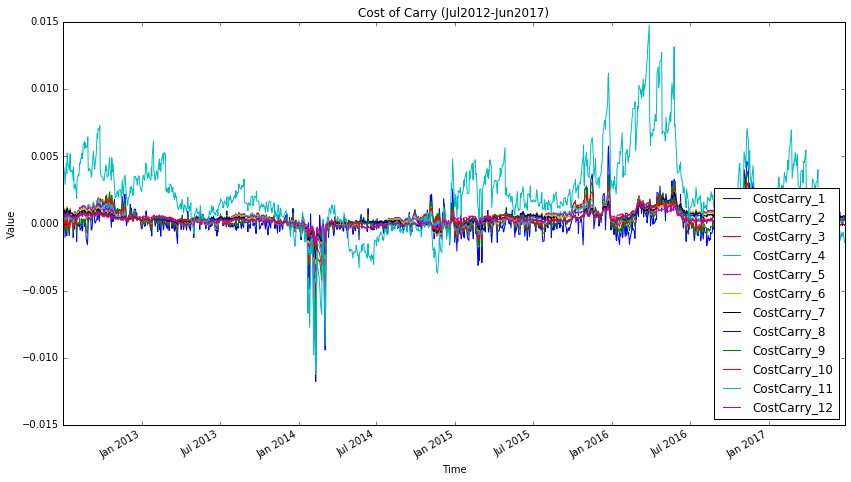

In [97]:
ax_carry = carry.plot(figsize=(14,8),title = "Cost of Carry (Jul2012-Jun2017)")
ax_carry.set_ylabel("Value")
ax_carry.set_xlabel("Time")

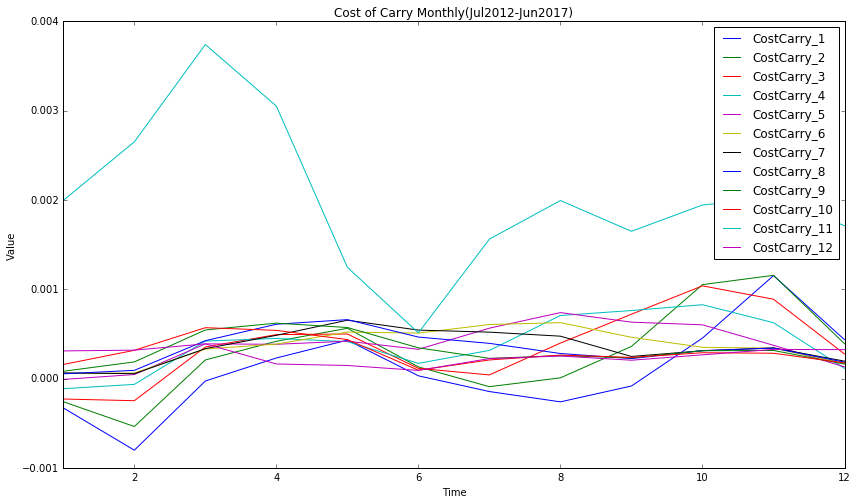

In [101]:
carry_monthly = carry.groupby(carry.index.month).mean()
#carry_monthly['All_Region'] = df_5yr_storage_monthly.sum(axis=1)
ax_carry_monthly = carry_monthly.plot(figsize=(14,8),title = "Cost of Carry Monthly(Jul2012-Jun2017)")
ax_carry_monthly.set_ylabel("Value")
ax_carry_monthly.set_xlabel("Time")

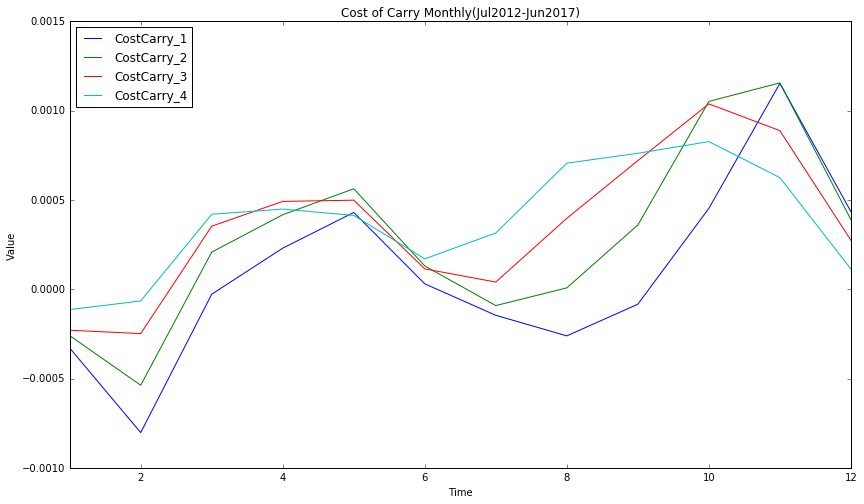

In [102]:
colsnew = carry_monthly.columns[0:4]
ax_carry_monthly = carry_monthly[colsnew].plot(figsize=(14,8),title = "Cost of Carry Monthly(Jul2012-Jun2017)")
ax_carry_monthly.set_ylabel("Value")
ax_carry_monthly.set_xlabel("Time")

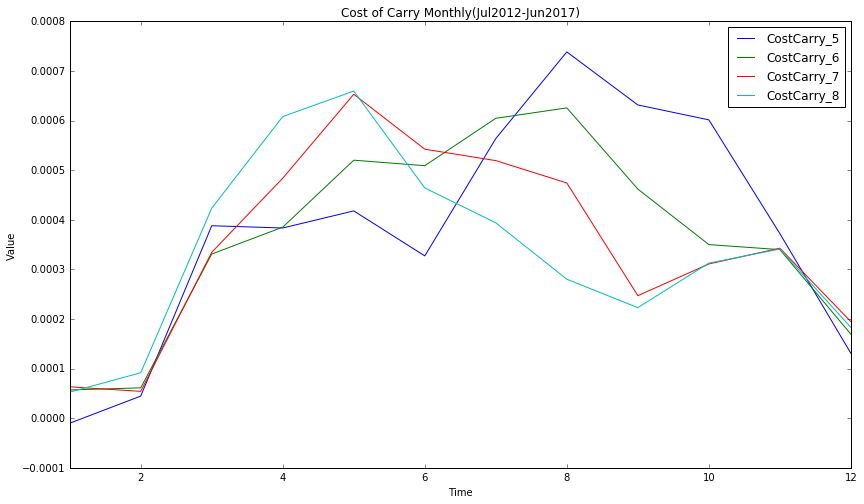

In [103]:
colsnew = carry_monthly.columns[4:8]
ax_carry_monthly = carry_monthly[colsnew].plot(figsize=(14,8),title = "Cost of Carry Monthly(Jul2012-Jun2017)")
ax_carry_monthly.set_ylabel("Value")
ax_carry_monthly.set_xlabel("Time")

In [105]:
#volume
import datetime
ticker = ['NG_FRONT','NG_FRONT2','NG_FRONT3','NG_FRONT4','NG_FRONT5','NG_FRONT6','NG_FRONT7',
          'NG_FRONT8','NG_FRONT9','NG_FRONT10','NG_FRONT11','NG_FRONT12'] 
field_name = ['VOLUME','VOLUME','VOLUME','VOLUME','VOLUME','VOLUME','VOLUME','VOLUME','VOLUME','VOLUME','VOLUME','VOLUME']
source = ['EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH','EXCH']

#print(len(ticker))
#print(len(field_name))
#print(len(source))
start_date = '01/02/1996'
end_date = '06/27/2017'
cal_type = 'WD'

crtConn = crtDbOpen()
df = pd.DataFrame()
whole_dataframes = {}
    
for i in range(0,len(ticker)):
            
    period_series_dict = {}                    
    statement ="Select * FROM dbo.CRTGetPeriodSeries('" + start_date + "' , '" + end_date + "' , '" + ticker[i] + "' , '" + field_name[i] + "' , '" + source[i] + "','" + cal_type + "')"
    get_period_series_list = crt_gen_sel (crtConn, statement, None,case="same")
        
    for row in get_period_series_list:
        dt = str(row[0])
        tmpDate = dt.split(' ')
        dt = tmpDate[0]           
        dt = datetime.datetime.strptime(dt,'%Y-%m-%d')
        t_year = dt.year            
        dbDate = str(dt).split(' ')
        dbDate = dbDate[0]
        dbDate = str(dbDate[:len(dbDate)-2] + str(t_year))           
        period_series_dict[dt] = row[1]
            
    statement = " TICKER like '" + ticker[i] + "' AND FIELDNAME = '" + field_name[i] + "' AND DATASOURCE = '" + source[i] + "'"
    TableName = 'CRTTICKERNAME'
    IdColName = 'tickerid'            
    get_id = crt_select_multiple_value(crtConn,TableName, IdColName, statement)            
    statement = " tickerid = " + get_id.get(1)
    statement = statement.replace(',','')
    statement = statement.strip()            
    TableName = 'CRTTICKERVALUE'
    IdColName = 'tickerValueDate,tickerValue'
    PP = crt_select_multiple_value(crtConn,TableName, IdColName, statement)        
    date_list = []
    value_list = []
            
    for key, value in iter(PP.items()):
        temp_value = PP.get(key)
        temp_value = temp_value.split(',')        
        dbValue = float(temp_value[1])
        dbDate = str(temp_value[0])
        dbDate = dbDate.split(' ')
        dbDate = dbDate[0]        
        tmpDate = datetime.datetime.strptime(dbDate,'%Y-%m-%d')               
        t_year = tmpDate.year                
        dbDate = str(dbDate[:len(dbDate)-2] + str(t_year))
                
        if period_series_dict.get(tmpDate):
            period_series_dict[tmpDate] = dbValue
        
    date_list = []
    value_list = [] 
    for key in sorted(period_series_dict.keys()):                
        dbDate = key
        dbValue = period_series_dict.get(key)                
        date_list.append(dbDate)
        value_list.append(dbValue)
        whole_dataframes[i] =  pd.DataFrame()
        
    s_PP = pd.Series(date_list)
    s_PP2 = pd.Series(value_list)
           
    whole_dataframes[i]['Date'] = s_PP
    whole_dataframes[i]['Date'] = pd.to_datetime(whole_dataframes[i]['Date']) #run
    whole_dataframes[i][ticker[i]+'_'+field_name[i]+'_'+source[i]] = s_PP2
            
whole_dataframes[0].index = whole_dataframes[0]['Date'].values  
whole_dataframes[0] = whole_dataframes[0].drop(['Date'],axis=1)
          
for i in range(1,len(ticker)):
    whole_dataframes[i].index = whole_dataframes[i]['Date'].values
    whole_dataframes[i] = whole_dataframes[i].drop(['Date'],axis=1)            
    whole_dataframes[0] = whole_dataframes[0].join(whole_dataframes[i])
df = whole_dataframes[0]

#df = df.dropna()
#df = df.fillna(df.mean())
date = df.index
dateList = []       
for tmp in date:
    tmpDate = str(tmp)  
    t_year = tmp.year
    t_month = tmp.month
    t_day = tmp.day          
    strDate = str(t_month) + '/' + str(t_day) + '/' + str(t_year)    
    dateList.append(strDate)
       
df['Date'] = dateList
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_volume = df[cols]
df_volume.head(1)

Date  NG_FRONT_VOLUME_EXCH  NG_FRONT2_VOLUME_EXCH  \
1996-01-02  1/2/1996                 13970                   2540   

            NG_FRONT3_VOLUME_EXCH  NG_FRONT4_VOLUME_EXCH  \
1996-01-02                   1276                    603   

            NG_FRONT5_VOLUME_EXCH  NG_FRONT6_VOLUME_EXCH  \
1996-01-02                    859                    615   

            NG_FRONT7_VOLUME_EXCH  NG_FRONT8_VOLUME_EXCH  \
1996-01-02                    289                    492   

            NG_FRONT9_VOLUME_EXCH  NG_FRONT10_VOLUME_EXCH  \
1996-01-02                    146                      79   

            NG_FRONT11_VOLUME_EXCH  NG_FRONT12_VOLUME_EXCH  
1996-01-02                      93                      22

In [107]:
df_volume_5yr = df_volume.drop('Date',axis=1)
df_volume_5yr = df_volume_5yr[4304:]
df_volume_5yr = df_volume_5yr.dropna()

In [108]:
df_volume_5yr.describe()

NG_FRONT_VOLUME_EXCH  NG_FRONT2_VOLUME_EXCH  NG_FRONT3_VOLUME_EXCH  \
count           1257.000000            1257.000000            1257.000000   
mean          132862.281623           75892.740652           39101.683373   
std            45706.723978           33589.298195           20376.250924   
min            30887.000000           11954.000000            7100.000000   
25%           101446.000000           51378.000000           24471.000000   
50%           131764.000000           72115.000000           34303.000000   
75%           160371.000000           95106.000000           48334.000000   
max           311657.000000          265616.000000          164153.000000   

       NG_FRONT4_VOLUME_EXCH  NG_FRONT5_VOLUME_EXCH  NG_FRONT6_VOLUME_EXCH  \
count            1257.000000            1257.000000            1257.000000   
mean            24378.944312           17555.282418           11934.583930   
std             12706.294523            9889.094596            7865.138081   
min              5030.000000            2878.000000            1383.000000   
25%             15509.000000           10530.000000            6352.000000   
50%             21872.000000           15577.000000           10091.000000   
75%             30055.000000           22324.000000           15491.000000   
max            111085.000000           67344.000000           61734.000000   

       NG_FRONT7_VOLUME_EXCH  NG_FRONT8_VOLUME_EXCH  NG_FRONT9_VOLUME_EXCH  \
count            1257.000000            1257.000000            1257.000000   
mean             9300.986476            7218.862371            6032.280827   
std              7923.425212            6395.627823            6194.829162   
min               975.000000             341.000000             232.000000   
25%              4140.000000            2776.000000            1837.000000   
50%              6889.000000            5274.000000            4057.000000   
75%             11756.000000            9439.000000            7906.000000   
max             85434.000000           56538.000000           51894.000000   

       NG_FRONT10_VOLUME_EXCH  NG_FRONT11_VOLUME_EXCH  NG_FRONT12_VOLUME_EXCH  
count             1257.000000             1257.000000             1257.000000  
mean              5033.739061             4081.329356             3235.118536  
std               5617.009736             4343.161431             3863.590491  
min                174.000000               85.000000              141.000000  
25%               1293.000000              968.000000              839.000000  
50%               3152.000000             2544.000000             1996.000000  
75%               6673.000000             5947.000000             4162.000000  
max              59125.000000            42189.000000            43965.000000

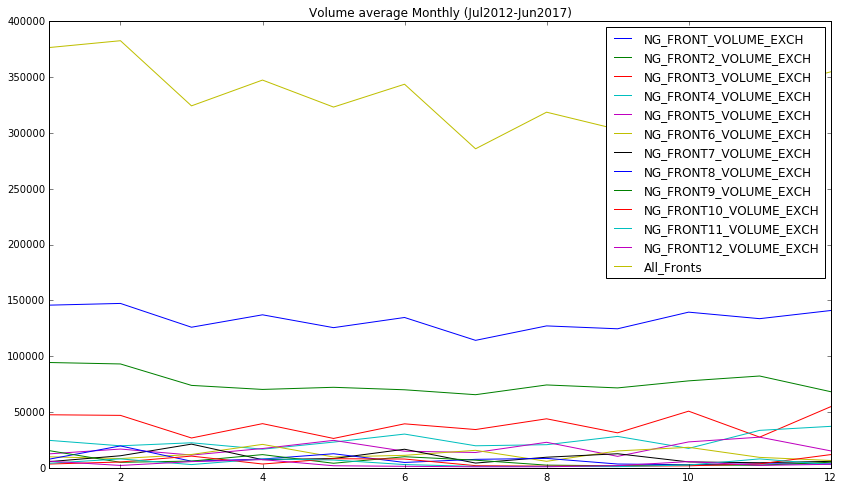

In [110]:
df_5yr_volume_monthly = df_volume_5yr.groupby(df_volume_5yr.index.month).mean()
df_5yr_volume_monthly['All_Fronts'] = df_5yr_volume_monthly.sum(axis=1)
ax_volume = df_5yr_volume_monthly.plot(figsize=(14,8),title = "Volume average Monthly (Jul2012-Jun2017)")

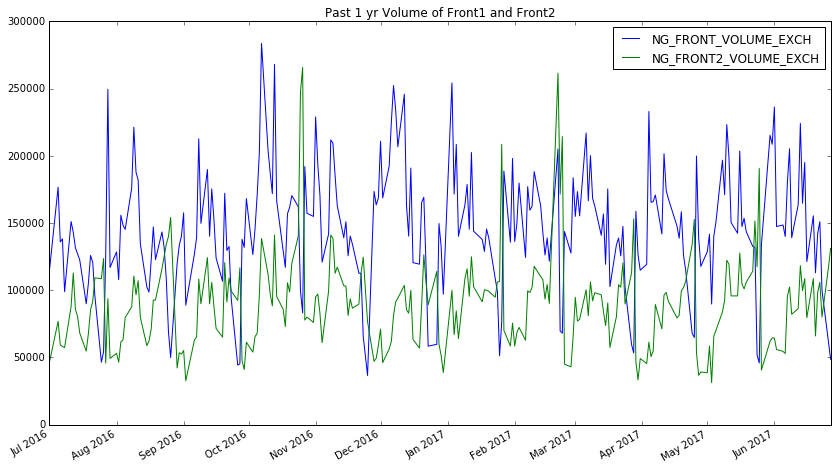

In [118]:
#just looking at front with ma
#volume 1 yr
df_volume_1yr = df_volume_5yr[1008:]
df_volume_1yr[['NG_FRONT_VOLUME_EXCH','NG_FRONT2_VOLUME_EXCH']].plot(legend = True,figsize=(14,8),title = "Past 1 yr Volume of Front1 and Front2")

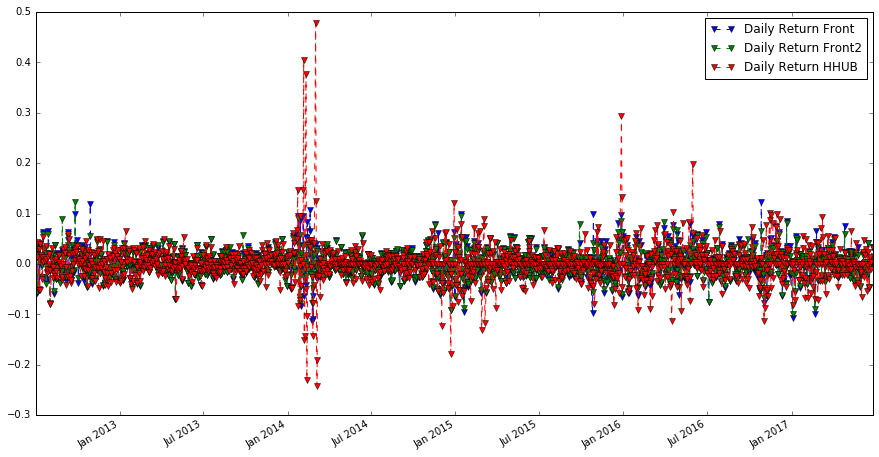

In [121]:
#hhub and 2 fronts for interest 
df_front_5yr = df_price_5yr[['NG_FRONT_CLOSE_EXCH','NG_FRONT2_CLOSE_EXCH','NG-HHUB_CLOSE_EIA']].dropna()
df_front_5yr['Daily Return Front'] = df_front_5yr['NG_FRONT_CLOSE_EXCH'].pct_change()
df_front_5yr['Daily Return Front2'] = df_front_5yr['NG_FRONT2_CLOSE_EXCH'].pct_change()
df_front_5yr['Daily Return HHUB'] = df_front_5yr['NG-HHUB_CLOSE_EIA'].pct_change()
df_front_5yr[['Daily Return Front','Daily Return Front2','Daily Return HHUB']].plot(legend=True,figsize=(15,8),ls='--',marker = 'v')

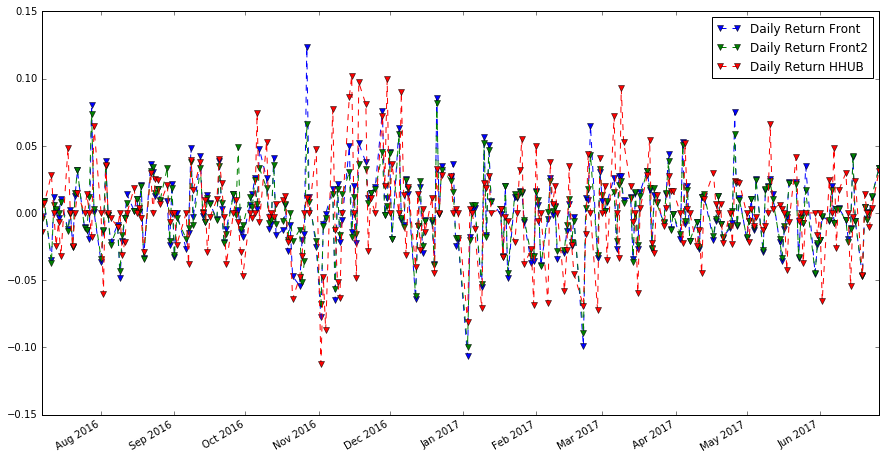

In [122]:
#1 yr
df_front_5yr[['Daily Return Front','Daily Return Front2','Daily Return HHUB']][1008:].plot(legend=True,figsize=(15,8),ls='--',marker = 'v')

In [129]:
front_ret = df_front_5yr[['NG_FRONT_CLOSE_EXCH','NG_FRONT2_CLOSE_EXCH','NG-HHUB_CLOSE_EIA']].pct_change()
front_ret.head()

NG_FRONT_CLOSE_EXCH  NG_FRONT2_CLOSE_EXCH  NG-HHUB_CLOSE_EIA
2012-07-02                  NaN                   NaN                NaN
2012-07-03             0.026558              0.027895           0.018315
2012-07-05             0.015868              0.013397           0.043165
2012-07-06            -0.057385             -0.055593           0.013793
2012-07-09             0.038545              0.032304          -0.051020

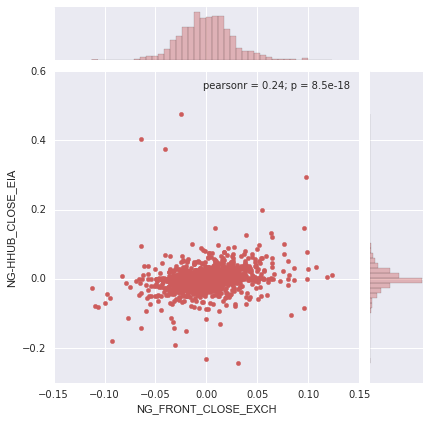

In [132]:
sns.jointplot('NG_FRONT_CLOSE_EXCH','NG-HHUB_CLOSE_EIA',front_ret,color='indianred',kind='scatter')
#did front 1 and front 2 and very close

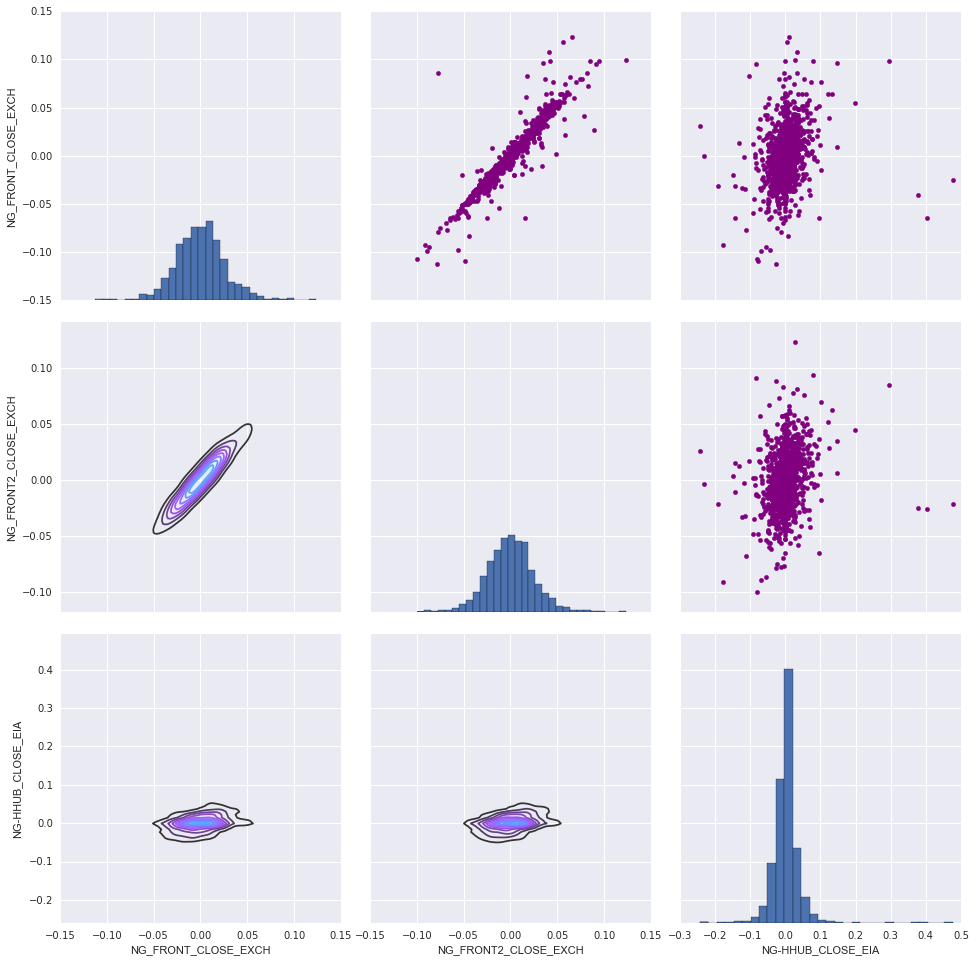

In [133]:
returns_fig = sns.PairGrid(front_ret.dropna(),size=4.5,aspect=1)

returns_fig.map_upper(plt.scatter,color='purple')

returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

returns_fig.map_diag(plt.hist,bins=30)

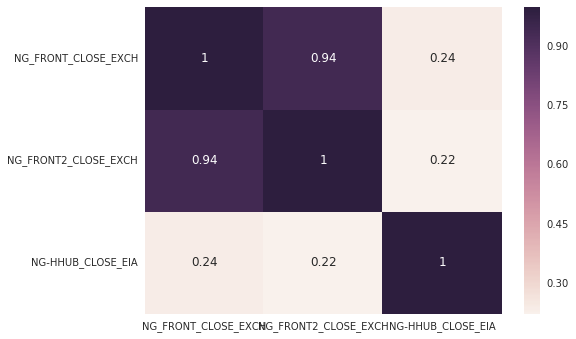

In [134]:
sns.heatmap(front_ret.dropna().corr(),annot=True) #returns

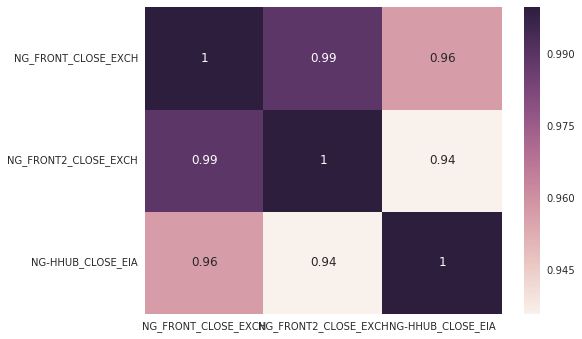

In [135]:
sns.heatmap(df_front_5yr[['NG_FRONT_CLOSE_EXCH','NG_FRONT2_CLOSE_EXCH','NG-HHUB_CLOSE_EIA']].corr(),annot=True) #price

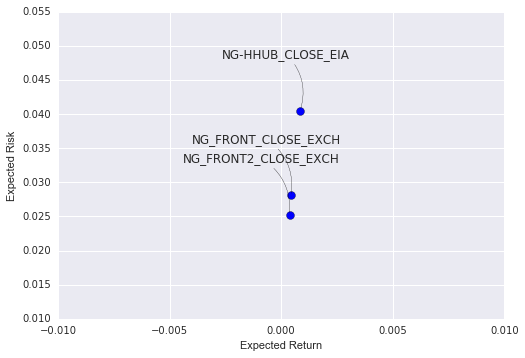

In [136]:
rets = front_ret.dropna()

area = np.pi*20

plt.scatter(rets.mean(),rets.std(),s = area)

plt.xlabel('Expected Return')
plt.ylabel('Expected Risk')

#Putting annotation
# http://matplotlib.org/users/annotations_guide.html
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (50, 50),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=-0.3'))

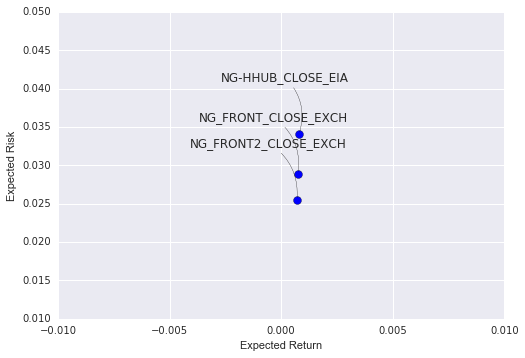

In [138]:
front_ret_1yr = front_ret[1008:]
rets2 = front_ret_1yr.dropna()

area = np.pi*20

plt.scatter(rets2.mean(),rets2.std(),s = area)

plt.xlabel('Expected Return')
plt.ylabel('Expected Risk')

#Putting annotation
# http://matplotlib.org/users/annotations_guide.html
for label, x, y in zip(rets2.columns, rets2.mean(), rets2.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (50, 50),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=-0.3'))
    #hhub not as risky as the 5 yr avg

In [139]:
days = 365

dt = 1/days

mu = rets2.mean()['NG_FRONT_CLOSE_EXCH']

sigma = rets2.std()['NG_FRONT_CLOSE_EXCH']

In [145]:
def stock_monte_carlo(start_price,days,mu,sigma):
    
    price = np.zeros(days)
    
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for i in range(1,days):
        
        drift[i] = mu * dt
        shock[i] = np.random.normal(loc=mu*dt,scale= sigma*np.sqrt(dt))
        
        price[i] = price[i-1] + (price[i-1]*(drift[i]+shock[i]))
        
    return price

In [ ]:
import math
import numpy
import random
import decimal
import scipy.linalg
import numpy.random as nrand
import matplotlib.pyplot as plt

"""
Note that this Gist uses the Model Parameters class found here  - https://gist.github.com/StuartGordonReid/f01f479c783dd40cc21e
"""

def cox_ingersoll_ross_levels(param):
    """
    This method returns the rate levels of a mean-reverting cox ingersoll ross process. It is used to model interest
    rates as well as stochastic volatility in the Heston model. Because the returns between the underlying and the
    stochastic volatility should be correlated we pass a correlated Brownian motion process into the method from which
    the interest rate levels are constructed. The other correlated process is used in the Heston model
    :param param: the model parameters object
    :return: the interest rate levels for the CIR process
    """
    brownian_motion = brownian_motion_log_returns(param)
    # Setup the parameters for interest rates
    a, mu, zero = param.cir_a, param.cir_mu, param.all_r0
    # Assumes output is in levels
    levels = [zero]
    for i in range(1, param.all_time):
        drift = a * (mu - levels[i-1]) * param.all_delta
        # The main difference between this and the Ornstein Uhlenbeck model is that we multiply the 'random'
        # component by the square-root of the previous level i.e. the process has level dependent interest rates.
        randomness = math.sqrt(levels[i - 1]) * brownian_motion[i - 1]
        levels.append(levels[i - 1] + drift + randomness)
    return numpy.array(levels)


In [142]:
df_front_5yr[['NG_FRONT_CLOSE_EXCH','NG_FRONT2_CLOSE_EXCH','NG-HHUB_CLOSE_EIA']][1008:].head(1)
#look at to see starting price of 1 yr ago

NG_FRONT_CLOSE_EXCH  NG_FRONT2_CLOSE_EXCH  NG-HHUB_CLOSE_EIA
2016-07-07                2.777                 2.764               2.78

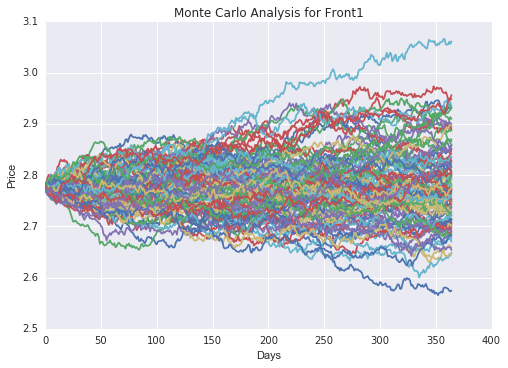

In [146]:
start_price = 2.777

for run in range(100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))
    
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis for Front1')

In [147]:
runs = 10000

simulations = np.zeros(runs)

for run in range(runs):
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]
q = np.percentile(simulations,1)

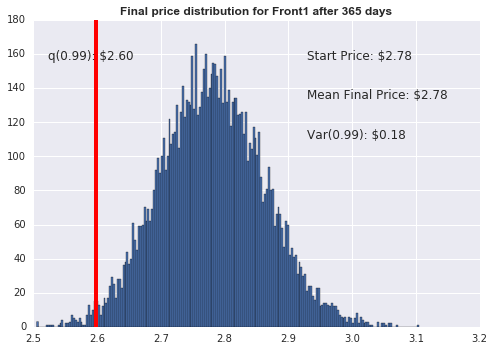

In [148]:
plt.hist(simulations,bins=200)

plt.figtext(0.6,0.8, s="Start Price: $%2.2f"%start_price)

plt.figtext(0.6,0.7, "Mean Final Price: $%2.2f"%simulations.mean())

plt.figtext(0.6,0.6, "Var(0.99): $%2.2f"%(start_price - q,))

plt.figtext(0.15,0.8,"q(0.99): $%2.2f"% q)

plt.axvline(x=q, linewidth=4,color='r')

plt.title("Final price distribution for Front1 after %s days"%days,weight = 'bold');


In [149]:
days = 365

dt = 1/days

mu = rets2.mean()['NG_FRONT2_CLOSE_EXCH']

sigma = rets2.std()['NG_FRONT2_CLOSE_EXCH']

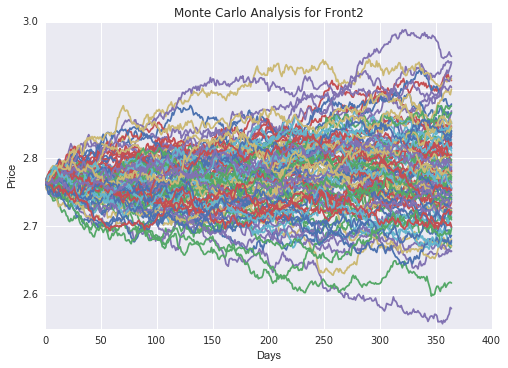

In [150]:
start_price = 2.764

for run in range(100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))
    
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis for Front2')

In [151]:
runs = 10000

simulations = np.zeros(runs)

for run in range(runs):
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]
q = np.percentile(simulations,1)

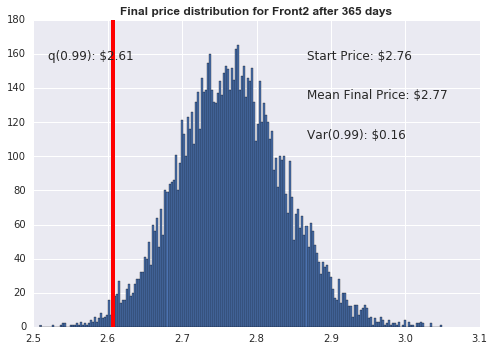

In [152]:
plt.hist(simulations,bins=200)
plt.figtext(0.6,0.8, s="Start Price: $%2.2f"%start_price)
plt.figtext(0.6,0.7, "Mean Final Price: $%2.2f"%simulations.mean())
plt.figtext(0.6,0.6, "Var(0.99): $%2.2f"%(start_price - q,))
plt.figtext(0.15,0.8,"q(0.99): $%2.2f"% q)
plt.axvline(x=q, linewidth=4,color='r')
plt.title("Final price distribution for Front2 after %s days"%days,weight = 'bold');

In [153]:
days = 365

dt = 1/days

mu = rets2.mean()['NG-HHUB_CLOSE_EIA']

sigma = rets2.std()['NG-HHUB_CLOSE_EIA']

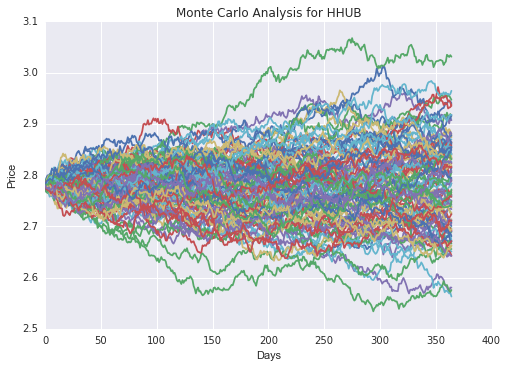

In [154]:
start_price = 2.78
#not necessarily correct because nat gas is mean reverting so should account for that
for run in range(100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))
    
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis for HHUB')

In [155]:
runs = 10000

simulations = np.zeros(runs)

for run in range(runs):
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]
q = np.percentile(simulations,1)

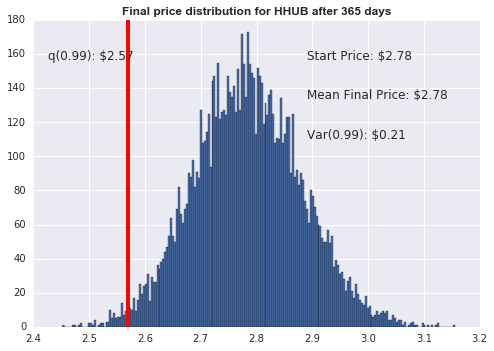

In [156]:
plt.hist(simulations,bins=200)
plt.figtext(0.6,0.8, s="Start Price: $%2.2f"%start_price)
plt.figtext(0.6,0.7, "Mean Final Price: $%2.2f"%simulations.mean())
plt.figtext(0.6,0.6, "Var(0.99): $%2.2f"%(start_price - q,))
plt.figtext(0.15,0.8,"q(0.99): $%2.2f"% q)
plt.axvline(x=q, linewidth=4,color='r')
plt.title("Final price distribution for HHUB after %s days"%days,weight = 'bold');

In [171]:
#comparative inventory
df_5yr = df2[4304:]
df_5yr_inv = df_5yr[['USA_NG-UNGD-STORAGE_ENERGY_SALT_EIA','USA_NG-UNGD-STORAGE_ENERGY_CTL-S_EIA','USA_NG-UNGD-STORAGE_ENERGY_PNW_EIA',
       'USA_NG-UNGD-STORAGE_ENERGY_NONSALT_EIA','USA_NG-UNGD-STORAGE_ENERGY_MTN_EIA','USA_NG-UNGD-STORAGE_ENERGY_MW_EIA',
       'USA_NG-UNGD-STORAGE_ENERGY_LOW48_EIA','USA_NG-UNGD-STORAGE_ENERGY_EAST_EIA','NG-HHUB_CLOSE_EIA']]
df_5yr_inv.head()

USA_NG-UNGD-STORAGE_ENERGY_SALT_EIA  \
2012-07-02                                  NaN   
2012-07-03                                  NaN   
2012-07-04                                  NaN   
2012-07-05                                  NaN   
2012-07-06                                  251   

            USA_NG-UNGD-STORAGE_ENERGY_CTL-S_EIA  \
2012-07-02                                   NaN   
2012-07-03                                   NaN   
2012-07-04                                   NaN   
2012-07-05                                   NaN   
2012-07-06                                  1079   

            USA_NG-UNGD-STORAGE_ENERGY_PNW_EIA  \
2012-07-02                                 NaN   
2012-07-03                                 NaN   
2012-07-04                                 NaN   
2012-07-05                                 NaN   
2012-07-06                                 360   

            USA_NG-UNGD-STORAGE_ENERGY_NONSALT_EIA  \
2012-07-02                                     NaN   
2012-07-03                                     NaN   
2012-07-04                                     NaN   
2012-07-05                                     NaN   
2012-07-06                                     828   

            USA_NG-UNGD-STORAGE_ENERGY_MTN_EIA  \
2012-07-02                                 NaN   
2012-07-03                                 NaN   
2012-07-04                                 NaN   
2012-07-05                                 NaN   
2012-07-06                                 174   

            USA_NG-UNGD-STORAGE_ENERGY_MW_EIA  \
2012-07-02                                NaN   
2012-07-03                                NaN   
2012-07-04                                NaN   
2012-07-05                                NaN   
2012-07-06                                775   

            USA_NG-UNGD-STORAGE_ENERGY_LOW48_EIA  \
2012-07-02                                   NaN   
2012-07-03                                   NaN   
2012-07-04                                   NaN   
2012-07-05                                   NaN   
2012-07-06                                  3135   

            USA_NG-UNGD-STORAGE_ENERGY_EAST_EIA  NG-HHUB_CLOSE_EIA  
2012-07-02                                  NaN               2.73  
2012-07-03                                  NaN               2.78  
2012-07-04                                  NaN                NaN  
2012-07-05                                  NaN               2.90  
2012-07-06                                  747               2.94

In [172]:
df_5yr_inv = df_5yr_inv.dropna()
df_5yr_inv_monthly = df_5yr_inv.resample('MS', how='mean')

In [179]:
storagecol = df_5yr_inv_monthly.columns[0:8]

In [180]:
df_5yr_inv_monthly['Storage_USA'] = df_5yr_inv_monthly[storagecol].sum(axis=1)
df_5yr_inv_monthly

USA_NG-UNGD-STORAGE_ENERGY_SALT_EIA  \
2012-07-01                           243.500000   
2012-08-01                           222.400000   
2012-09-01                           225.250000   
2012-10-01                           279.250000   
2012-11-01                           312.200000   
2012-12-01                           311.000000   
2013-01-01                           265.500000   
2013-02-01                           226.750000   
2013-03-01                           180.750000   
2013-04-01                           183.000000   
2013-05-01                           235.200000   
2013-06-01                           262.000000   
2013-07-01                           272.500000   
2013-08-01                           261.000000   
2013-09-01                           266.500000   
2013-10-01                           302.500000   
2013-11-01                           323.600000   
2013-12-01                           279.500000   
2014-01-01                           199.600000   
2014-02-01                            92.500000   
2014-03-01                            60.250000   
2014-04-01                            82.666667   
2014-05-01                           138.800000   
2014-06-01                           180.500000   
2014-07-01                           206.000000   
2014-08-01                           212.000000   
2014-09-01                           230.000000   
2014-10-01                           285.800000   
2014-11-01                           319.000000   
2014-12-01                           326.250000   
2015-01-01                           275.800000   
2015-02-01                           192.500000   
2015-03-01                           117.250000   
2015-04-01                           190.333333   
2015-05-01                           251.000000   
2015-06-01                           293.250000   
2015-07-01                           299.600000   
2015-08-01                           288.500000   
2015-09-01                           306.000000   
2015-10-01                           354.200000   
2015-11-01                           378.000000   
2015-12-01                           377.750000   
2016-01-01                           342.400000   
2016-02-01                           291.000000   
2016-03-01                           305.250000   
2016-04-01                           342.600000   
2016-05-01                           370.250000   
2016-06-01                           366.000000   
2016-07-01                           342.800000   
2016-08-01                           299.250000   
2016-09-01                           281.400000   
2016-10-01                           340.250000   
2016-11-01                           393.750000   
2016-12-01                           364.200000   
2017-01-01                           330.000000   
2017-02-01                           332.750000   
2017-03-01                           306.000000   
2017-04-01                           316.250000   
2017-05-01                           337.000000   
2017-06-01                           344.250000   

            USA_NG-UNGD-STORAGE_ENERGY_CTL-S_EIA  \
2012-07-01                           1077.750000   
2012-08-01                           1071.800000   
2012-09-01                           1098.000000   
2012-10-01                           1197.250000   
2012-11-01                           1236.200000   
2012-12-01                           1208.000000   
2013-01-01                           1044.000000   
2013-02-01                            900.000000   
2013-03-01                            732.250000   
2013-04-01                            673.250000   
2013-05-01                            789.400000   
2013-06-01                            908.250000   
2013-07-01                            983.250000   
2013-08-01                           1030.400000   
2013-09-01                           1089.000000   
2013-10-01                           1194.000000   
2013-11-01      

In [182]:
x1new = df_5yr_inv_monthly['Storage_USA']
x2new = df_5yr_inv_monthly['NG-HHUB_CLOSE_EIA']
df_5yr_inv_monthly['1 Yr Moving Corr'] = pd.rolling_corr(x1new,x2new,window = 12)
df_5yr_inv_monthly.head(13)

USA_NG-UNGD-STORAGE_ENERGY_SALT_EIA  \
2012-07-01                               243.50   
2012-08-01                               222.40   
2012-09-01                               225.25   
2012-10-01                               279.25   
2012-11-01                               312.20   
2012-12-01                               311.00   
2013-01-01                               265.50   
2013-02-01                               226.75   
2013-03-01                               180.75   
2013-04-01                               183.00   
2013-05-01                               235.20   
2013-06-01                               262.00   
2013-07-01                               272.50   

            USA_NG-UNGD-STORAGE_ENERGY_CTL-S_EIA  \
2012-07-01                               1077.75   
2012-08-01                               1071.80   
2012-09-01                               1098.00   
2012-10-01                               1197.25   
2012-11-01                               1236.20   
2012-12-01                               1208.00   
2013-01-01                               1044.00   
2013-02-01                                900.00   
2013-03-01                                732.25   
2013-04-01                                673.25   
2013-05-01                                789.40   
2013-06-01                                908.25   
2013-07-01                                983.25   

            USA_NG-UNGD-STORAGE_ENERGY_PNW_EIA  \
2012-07-01                              362.00   
2012-08-01                              349.40   
2012-09-01                              342.75   
2012-10-01                              358.25   
2012-11-01                              375.80   
2012-12-01                              365.00   
2013-01-01                              302.25   
2013-02-01                              261.50   
2013-03-01                              247.00   
2013-04-01                              258.50   
2013-05-01                              285.80   
2013-06-01                              325.00   
2013-07-01                              337.00   

            USA_NG-UNGD-STORAGE_ENERGY_NONSALT_EIA  \
2012-07-01                                  834.25   
2012-08-01                                  849.40   
2012-09-01                                  872.75   
2012-10-01                                  918.00   
2012-11-01                                  924.00   
2012-12-01                                  897.00   
2013-01-01                                  778.50   
2013-02-01                                  673.25   
2013-03-01                                  551.50   
2013-04-01                                  490.25   
2013-05-01                                  554.20   
2013-06-01                                  646.25   
2013-07-01                                  710.75   

            USA_NG-UNGD-STORAGE_ENERGY_MTN_EIA  \
2012-07-01                              179.75   
2012-08-01                              193.00   
2012-09-01                              210.75   
2012-10-01                              223.25   
2012-11-01                              228.80   
2012-12-01                              218.25   
2013-01-01                              184.25   
2013-02-01                              155.75   
2013-03-01                              133.50   
2013-04-01                              119.50   
2013-05-01                              123.80   
2013-06-01                              142.25   
2013-07-01                              155.75   

            USA_NG-UNGD-STORAGE_ENERGY_MW_EIA  \
2012-07-01                             796.25   
2012-08-01                             886.60   
2012-09-01                            1004.25   
2012-10-01                            1091.75   
2012-11-01                            1104.80   
2012-12-01                            1013.50   
2013-01-01                             823.00   
2013-02-01       

In [183]:
df_5yr_inv_monthly.describe()

USA_NG-UNGD-STORAGE_ENERGY_SALT_EIA  \
count                            60.000000   
mean                            271.922500   
std                              76.369874   
min                              60.250000   
25%                             226.375000   
50%                             287.150000   
75%                             327.187500   
max                             393.750000   

       USA_NG-UNGD-STORAGE_ENERGY_CTL-S_EIA  \
count                             60.000000   
mean                             994.591667   
std                              243.151725   
min                              359.000000   
25%                              854.150000   
50%                             1055.750000   
75%                             1183.875000   
max                             1360.750000   

       USA_NG-UNGD-STORAGE_ENERGY_PNW_EIA  \
count                           60.000000   
mean                           294.733889   
std                             63.569346   
min                            102.750000   
25%                            261.062500   
50%                            304.750000   
75%                            342.875000   
max                            382.500000   

       USA_NG-UNGD-STORAGE_ENERGY_NONSALT_EIA  \
count                               60.000000   
mean                               722.644167   
std                                175.015240   
min                                284.000000   
25%                                632.500000   
50%                                751.375000   
75%                                875.000000   
max                                967.250000   

       USA_NG-UNGD-STORAGE_ENERGY_MTN_EIA  USA_NG-UNGD-STORAGE_ENERGY_MW_EIA  \
count                           60.000000                          60.000000   
mean                           168.813056                         715.545278   
std                             40.402305                         269.069076   
min                             81.666667                         142.666667   
25%                            141.537500                         538.162500   
50%                            169.125000                         720.300000   
75%                            196.750000                         932.737500   
max                            256.750000                        1146.500000   

       USA_NG-UNGD-STORAGE_ENERGY_LOW48_EIA  \
count                             60.000000   
mean                            2798.665000   
std                              797.600195   
min                              886.000000   
25%                             2336.200000   
50%                             2851.750000   
75%                             3390.550000   
max                             4026.000000   

       USA_NG-UNGD-STORAGE_ENERGY_EAST_EIA  NG-HHUB_CLOSE_EIA  Storage_USA  \
count                            60.000000          60.000000    60.000000   
mean                            625.029722           3.238642  6591.945278   
std                             222.975013           0.807336  1822.613506   
min                             178.000000           1.712500  2139.333333   
25%                             432.650000           2.794500  5513.575000   
50%                             636.575000           3.130000  6770.500000   
75%                             814.200000           3.745000  7896.812500   
max                             941.750000           5.625000  9412.750000   

       1 Yr Moving Corr  
count         49.000000  
mean          -0.203873  
std            0.527051  
min           -0.756236  
25%           -0.706517  
50%           -0.315392  
75%            0.275802  
max            0.745297

C:\Users\msteinme\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


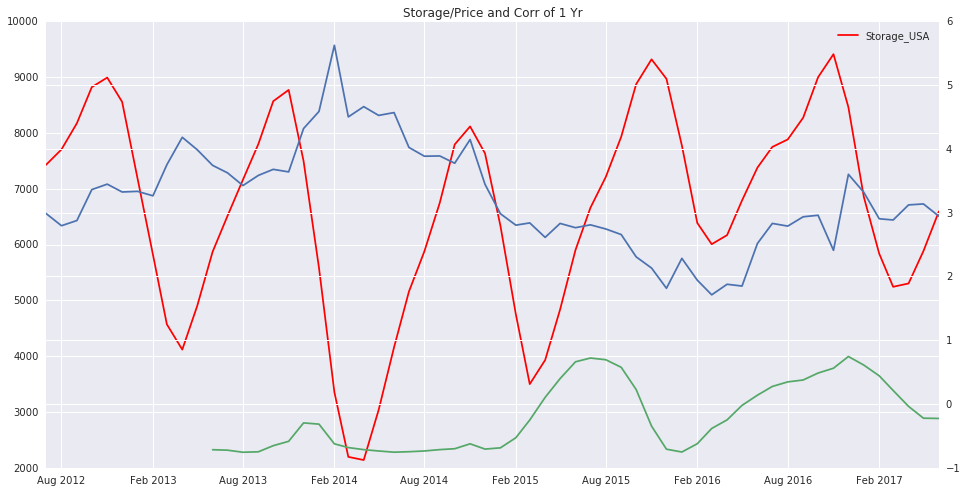

In [210]:
fig = plt.figure(facecolor='white',figsize=(16,8))
ax = plt.gca()
ax2 = ax.twinx()
plt.axis('normal')
ax.plot(df_5yr_inv_monthly[['Storage_USA']],color='r',label = 'Storage_USA')
labels = ['Henry Hub','Correlation']
ax2.plot(df_5yr_inv_monthly[['NG-HHUB_CLOSE_EIA','1 Yr Moving Corr']])
ax.set_title("Storage/Price and Corr of 1 Yr")
ax.legend(loc='best',prop={'size':10})
ax2.legend(loc='upper left',prop={'size':10})
plt.show()

In [211]:
#lng import price and export price 5 yr back
import datetime
ticker = ['NG_FRONT','NG-HHUB','INDEX_CRY','USA_LNG','USA_LNG'] 
field_name = ['CLOSE','CLOSE','CLOSE','ENERGY_IMPORT','ENERGY_EXPORT']
source = ['EXCH','EIA','PUB','EIA','EIA']

#print(len(ticker))
#print(len(field_name))
#print(len(source))
start_date = '07/02/2012'
end_date = '06/27/2017'
cal_type = 'WD'

crtConn = crtDbOpen()
df = pd.DataFrame()
whole_dataframes = {}
    
for i in range(0,len(ticker)):
            
    period_series_dict = {}                    
    statement ="Select * FROM dbo.CRTGetPeriodSeries('" + start_date + "' , '" + end_date + "' , '" + ticker[i] + "' , '" + field_name[i] + "' , '" + source[i] + "','" + cal_type + "')"
    get_period_series_list = crt_gen_sel (crtConn, statement, None,case="same")
        
    for row in get_period_series_list:
        dt = str(row[0])
        tmpDate = dt.split(' ')
        dt = tmpDate[0]           
        dt = datetime.datetime.strptime(dt,'%Y-%m-%d')
        t_year = dt.year            
        dbDate = str(dt).split(' ')
        dbDate = dbDate[0]
        dbDate = str(dbDate[:len(dbDate)-2] + str(t_year))           
        period_series_dict[dt] = row[1]
            
    statement = " TICKER like '" + ticker[i] + "' AND FIELDNAME = '" + field_name[i] + "' AND DATASOURCE = '" + source[i] + "'"
    TableName = 'CRTTICKERNAME'
    IdColName = 'tickerid'            
    get_id = crt_select_multiple_value(crtConn,TableName, IdColName, statement)            
    statement = " tickerid = " + get_id.get(1)
    statement = statement.replace(',','')
    statement = statement.strip()            
    TableName = 'CRTTICKERVALUE'
    IdColName = 'tickerValueDate,tickerValue'
    PP = crt_select_multiple_value(crtConn,TableName, IdColName, statement)        
    date_list = []
    value_list = []
            
    for key, value in iter(PP.items()):
        temp_value = PP.get(key)
        temp_value = temp_value.split(',')        
        dbValue = float(temp_value[1])
        dbDate = str(temp_value[0])
        dbDate = dbDate.split(' ')
        dbDate = dbDate[0]        
        tmpDate = datetime.datetime.strptime(dbDate,'%Y-%m-%d')               
        t_year = tmpDate.year                
        dbDate = str(dbDate[:len(dbDate)-2] + str(t_year))
                
        if period_series_dict.get(tmpDate):
            period_series_dict[tmpDate] = dbValue
        
    date_list = []
    value_list = [] 
    for key in sorted(period_series_dict.keys()):                
        dbDate = key
        dbValue = period_series_dict.get(key)                
        date_list.append(dbDate)
        value_list.append(dbValue)
        whole_dataframes[i] =  pd.DataFrame()
        
    s_PP = pd.Series(date_list)
    s_PP2 = pd.Series(value_list)
           
    whole_dataframes[i]['Date'] = s_PP
    whole_dataframes[i]['Date'] = pd.to_datetime(whole_dataframes[i]['Date']) #run
    whole_dataframes[i][ticker[i]+'_'+field_name[i]+'_'+source[i]] = s_PP2
            
whole_dataframes[0].index = whole_dataframes[0]['Date'].values  
whole_dataframes[0] = whole_dataframes[0].drop(['Date'],axis=1)
          
for i in range(1,len(ticker)):
    whole_dataframes[i].index = whole_dataframes[i]['Date'].values
    whole_dataframes[i] = whole_dataframes[i].drop(['Date'],axis=1)            
    whole_dataframes[0] = whole_dataframes[0].join(whole_dataframes[i])
df = whole_dataframes[0]

#df = df.dropna()
#df = df.fillna(df.mean())
date = df.index
dateList = []       
for tmp in date:
    tmpDate = str(tmp)  
    t_year = tmp.year
    t_month = tmp.month
    t_day = tmp.day          
    strDate = str(t_month) + '/' + str(t_day) + '/' + str(t_year)    
    dateList.append(strDate)
       
df['Date'] = dateList
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_volume = df[cols]
df_volume.head(1)

Date  NG_FRONT_CLOSE_EXCH  NG-HHUB_CLOSE_EIA  \
2012-07-02  7/2/2012                2.824               2.73   

            INDEX_CRY_CLOSE_PUB  USA_LNG_ENERGY_IMPORT_EIA  \
2012-07-02               284.21                        NaN   

            USA_LNG_ENERGY_EXPORT_EIA  
2012-07-02                        NaN

In [212]:
df_lng_5yr = df_volume.drop("Date",axis=1)
df_lng_5yr.head(1)

NG_FRONT_CLOSE_EXCH  NG-HHUB_CLOSE_EIA  INDEX_CRY_CLOSE_PUB  \
2012-07-02                2.824               2.73               284.21   

            USA_LNG_ENERGY_IMPORT_EIA  USA_LNG_ENERGY_EXPORT_EIA  
2012-07-02                        NaN                        NaN

In [215]:
lng_cols = df_lng_5yr.columns

Index(['NG_FRONT_CLOSE_EXCH', 'NG-HHUB_CLOSE_EIA', 'INDEX_CRY_CLOSE_PUB',
       'USA_LNG_ENERGY_IMPORT_EIA', 'USA_LNG_ENERGY_EXPORT_EIA'],
      dtype='object')

In [218]:
df_lng_5yr

NG_FRONT_CLOSE_EXCH  NG-HHUB_CLOSE_EIA  INDEX_CRY_CLOSE_PUB  \
2012-07-02                2.824               2.73             284.2100   
2012-07-03                2.899               2.78             292.6400   
2012-07-04                  NaN                NaN             292.6400   
2012-07-05                2.945               2.90             293.2600   
2012-07-06                2.776               2.94             286.9200   
2012-07-09                2.883               2.79             292.7000   
2012-07-10                2.737               2.87             288.6400   
2012-07-11                2.853               2.72             290.7900   
2012-07-12                2.874               2.83             290.2700   
2012-07-13                2.874               2.88             293.9600   
2012-07-16                2.801               2.92             295.9800   
2012-07-17                2.796               2.83             295.6400   
2012-07-18                2.973               2.84             299.0800   
2012-07-19                2.999               2.99             304.9700   
2012-07-20                3.081               3.03             304.5700   
2012-07-23                3.117               3.05             298.8800   
2012-07-24                3.187               3.16             296.3700   
2012-07-25                3.070               3.19             297.2400   
2012-07-26                3.105               3.13             297.4700   
2012-07-27                3.015               3.10             299.6000   
2012-07-30                3.214               3.14             302.5000   
2012-07-31                3.209               3.20             299.5100   
2012-08-01                3.171               3.20             299.2300   
2012-08-02                2.920               3.16             294.5000   
2012-08-03                2.877               2.91             300.6900   
2012-08-06                2.908               2.90             301.7500   
2012-08-07                2.964               2.99             303.8700   
2012-08-08                2.933               2.97             304.3200   
2012-08-09                2.945               2.89             304.8100   
2012-08-10                2.770               2.84             301.8100   
...                         ...                ...                  ...   
2017-05-17                3.192               3.27             183.2436   
2017-05-18                3.182               3.13             182.5066   
2017-05-19                3.256               3.11             185.0767   
2017-05-22                3.330               3.24             186.0732   
2017-05-23                3.219               3.22             185.0557   
2017-05-24                3.209               3.22             183.9182   
2017-05-25                3.184               3.10             181.1525   
2017-05-26                3.294               3.10             182.0048   
2017-05-29                  NaN               3.10                  NaN   
2017-05-30                3.145               3.10             181.3280   
2017-05-31                3.071               3.05             179.7724   
2017-06-01                3.008               3.05             179.0900   
2017-06-02                2.999               2.85             177.9633   
2017-06-05                2.982               2.92             177.2955   
2017-06-06                3.042               2.92             178.0767   
2017-06-07                3.020               3.06             175.6109   
2017-06-08                3.028               2.98             176.0976   
2017-06-09                3.039               3.03             176.7649   
2017-06-12                3.024               3.12             175.9340   
2017-06-13                2.966               3.12             175.8346   
2017-06-14                2.933               2.95             173.0239   
2017-06-15                3.056      

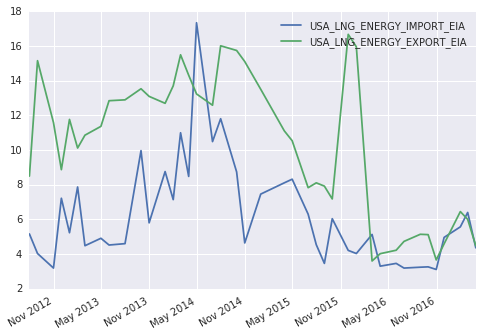

In [223]:
ax = df_lng_5yr[['USA_LNG_ENERGY_IMPORT_EIA', 'USA_LNG_ENERGY_EXPORT_EIA']].dropna().plot()
ax.legend(loc='upper right',prop={'size':10})

In [224]:
df_5yr_lng_monthly = df_lng_5yr.resample('MS', how='mean')
df_5yr_lng_monthly = df_5yr_lng_monthly.dropna()
df_5yr_lng_monthly.head(2)

NG_FRONT_CLOSE_EXCH  NG-HHUB_CLOSE_EIA  INDEX_CRY_CLOSE_PUB  \
2012-07-01             2.963429           2.953333           295.356364   
2012-08-01             2.809652           2.838261           303.808261   

            USA_LNG_ENERGY_IMPORT_EIA  USA_LNG_ENERGY_EXPORT_EIA  
2012-07-01                       5.15                       8.49  
2012-08-01                       4.02                      15.15

In [225]:
df_5yr_lng_monthly['INDEX_CRY_CLOSE_PUB'] = df_5yr_lng_monthly['INDEX_CRY_CLOSE_PUB']/100.
df_5yr_lng_monthly.head(1)

NG_FRONT_CLOSE_EXCH  NG-HHUB_CLOSE_EIA  INDEX_CRY_CLOSE_PUB  \
2012-07-01             2.963429           2.953333             2.953564   

            USA_LNG_ENERGY_IMPORT_EIA  USA_LNG_ENERGY_EXPORT_EIA  
2012-07-01                       5.15                       8.49

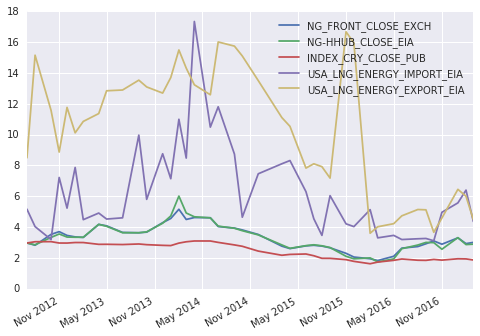

In [226]:
df_5yr_lng_monthly.plot()

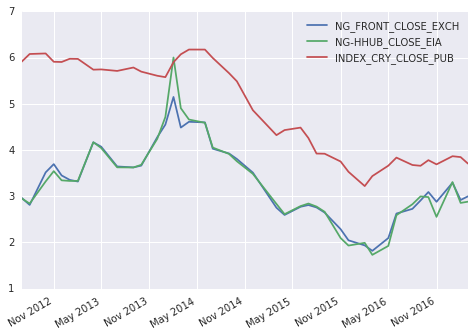

In [230]:
df_5yr_lng_monthly['INDEX_CRY_CLOSE_PUB'] = df_5yr_lng_monthly['INDEX_CRY_CLOSE_PUB']*2
df_5yr_lng_monthly[['NG_FRONT_CLOSE_EXCH','NG-HHUB_CLOSE_EIA','INDEX_CRY_CLOSE_PUB']].plot()